# Diabetes Risk Detection (Binary Classification)

- **Project Description**

In this project I explored a kaggle dataset with historical data regarding patients who were or were not diagnosed with diabetes.

- **Evaluation Metric:** ROc-AUC Score

# 00 Notebook Setup

## Imports

In [ ]:
pip install kagglehub[pandas-datasets] -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install hyperopt -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import xgboost as xgb

In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

/usr/local/python/3.12.1/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Load Dataset

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mohankrishnathalla/diabetes-health-indicators-dataset",
  'diabetes_dataset.csv'
  )

/tmp/ipykernel_40815/274157108.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


## Functions

In [ ]:
# Function to display the main information about a dataset

def display_main_info(df):
    print(f'\n ________________Head________________ \n')
    display(df.head())
    
    print(f'\n ________________Data Types Info________________ \n')
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   • {dtype}: {count} columns")
    
    print(f'\n ________________Shape________________\n')
    display(df.shape)
    
    print(f'\n Dataset contains {df.shape[0]} observations and {df.shape[1]} features \n')
    print(f'\n ________________Duplicates________________ \n')
    display(df.duplicated().sum())

    print(f'\n ________________Proportion of Missing Data________________ \n')
    missing_columns = df.columns[df.isnull().any()]
    print(f"\n Columns with missing values:")
    print(missing_columns.tolist())
    

In [ ]:
# Function to plot distributions of continuous values and statistical information

def plot_density_and_boxplot(df, col_name, target_col=None):
    print()
    print(f'============== Distribution of feature: {col_name} ==============')
    print()
    print('Statistics')

    display(df[col_name].describe().to_frame().T)
    print()
    print()

    # overall distribution with boxplot
    plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    
    ax_hist = plt.subplot(gs[0])
    ax_box = plt.subplot(gs[1])
    
    # Histogram
    sns.histplot(data=df, x=col_name, bins='sturges', alpha=0.7, 
                 edgecolor='black', ax=ax_hist, kde=True)
    ax_hist.set_title(f'Distribution of {col_name}')
    ax_hist.set_ylabel('Frequency')
    
    # Boxplot
    sns.boxplot(data=df, x=col_name, ax=ax_box)
    ax_box.set_xlabel(col_name)
    
    plt.tight_layout()
    plt.show()

    # Distribution by target (if target_col is provided)
    if target_col is not None and target_col in df.columns:
        print()
        print(f'============== Distribution of {col_name} by target ==============')
        
        # data for each class
        df_0 = df[df[target_col] == 0]
        df_1 = df[df[target_col] == 1]
        
        # Plot 1: Overlaid histograms for both classes
        plt.figure(figsize=(12, 6))
        
        sns.histplot(data=df_0, x=col_name, bins='sturges', alpha=0.6, 
                     edgecolor='black', color='skyblue', label='Class 0')
        sns.histplot(data=df_1, x=col_name, bins='sturges', alpha=0.6, 
                     edgecolor='black', color='lightcoral', label='Class 1')
        plt.title(f'Histogram of {col_name} by target class')
        plt.xlabel(col_name)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
        # Statistics by class
        print('\nStatistics by class:')
        print(f"Class 0 (n={len(df_0)}):")
        display(df_0[col_name].describe().to_frame().T)
        print(f"Class 1 (n={len(df_1)}):")
        display(df_1[col_name].describe().to_frame().T)

In [ ]:
# Function to plot distributions of categoric values and statistical information

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct, v=val)
    return my_autopct


def plot_pie_chart(df, col_name, target_col_name=None):
    plt.figure(figsize=(10, 5))
    
    df[col_name].value_counts().plot(
        kind='pie', 
        autopct=make_autopct(df[col_name].value_counts()), 
        fontsize=12
    )
    
    plt.title(f'Distribution of Feature: {col_name}', fontsize=12)
    plt.ylabel('') 
    plt.show()
    

    print(f'Number of unique values: {df[col_name].nunique()}')
    

    if target_col_name is not None:
        print(f'\nDistribution of {col_name} by Target Variable')
        print('=' * 50)
        
        target_by_category = round(df.groupby(col_name, observed=True)[target_col_name].mean(), 2)
        display(target_by_category)

# 01 EDA

## Overview

In [ ]:
df.loc[0]

age                                             58
gender                                        Male
ethnicity                                    Asian
education_level                         Highschool
income_level                          Lower-Middle
employment_status                         Employed
smoking_status                               Never
alcohol_consumption_per_week                     0
physical_activity_minutes_per_week             215
diet_score                                     5.7
sleep_hours_per_day                            7.9
screen_time_hours_per_day                      7.9
family_history_diabetes                          0
hypertension_history                             0
cardiovascular_history                           0
bmi                                           30.5
waist_to_hip_ratio                            0.89
systolic_bp                                    134
diastolic_bp                                    78
heart_rate                     

In [ ]:
display_main_info(df)


 ________________Head________________ 



,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1



 ________________Data Types Info________________ 

   • int64: 16 columns
   • float64: 8 columns
   • object: 7 columns

 ________________Shape________________



(100000, 31)


 Dataset contains 100000 observations and 31 features 


 ________________Duplicates________________ 



np.int64(0)


 ________________Proportion of Missing Data________________ 


 Columns with missing values:
[]


## Target 

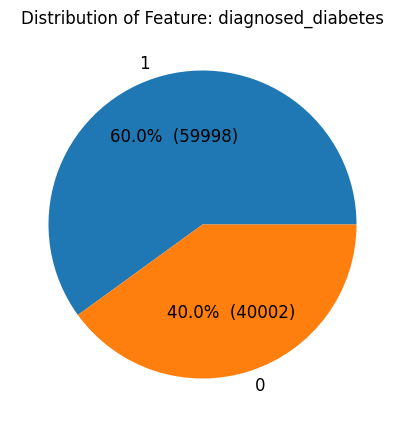

Number of unique values: 2


In [ ]:
plot_pie_chart(df, 'diagnosed_diabetes')

**Observations:**

- Target is imbalanced.

## Numeric Features

In [ ]:
num_cols = df.select_dtypes(include='number').columns.tolist()

In [ ]:
# Let's see if there are any categoric features shown as numeric
df[num_cols].nunique()

age                                     73
alcohol_consumption_per_week            11
physical_activity_minutes_per_week     620
diet_score                             101
sleep_hours_per_day                     71
screen_time_hours_per_day              156
family_history_diabetes                  2
hypertension_history                     2
cardiovascular_history                   2
bmi                                    240
waist_to_hip_ratio                      40
systolic_bp                             86
diastolic_bp                            60
heart_rate                              64
cholesterol_total                      210
hdl_cholesterol                         79
ldl_cholesterol                        190
triglycerides                          262
glucose_fasting                        109
glucose_postprandial                   210
insulin_level                         2350
hba1c                                  548
diabetes_risk_score                    569
diagnosed_d

There are a few features which are not continuous values, so I'll remove them and analyse as categoric features further on.

In [ ]:
cat_cols_to_drop = ['diagnosed_diabetes', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'alcohol_consumption_per_week']
for col in cat_cols_to_drop:
    num_cols.remove(col) 


============== Distribution of feature: age ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
age,100000.0,50.12041,15.6046,18.0,39.0,50.0,61.0,90.0


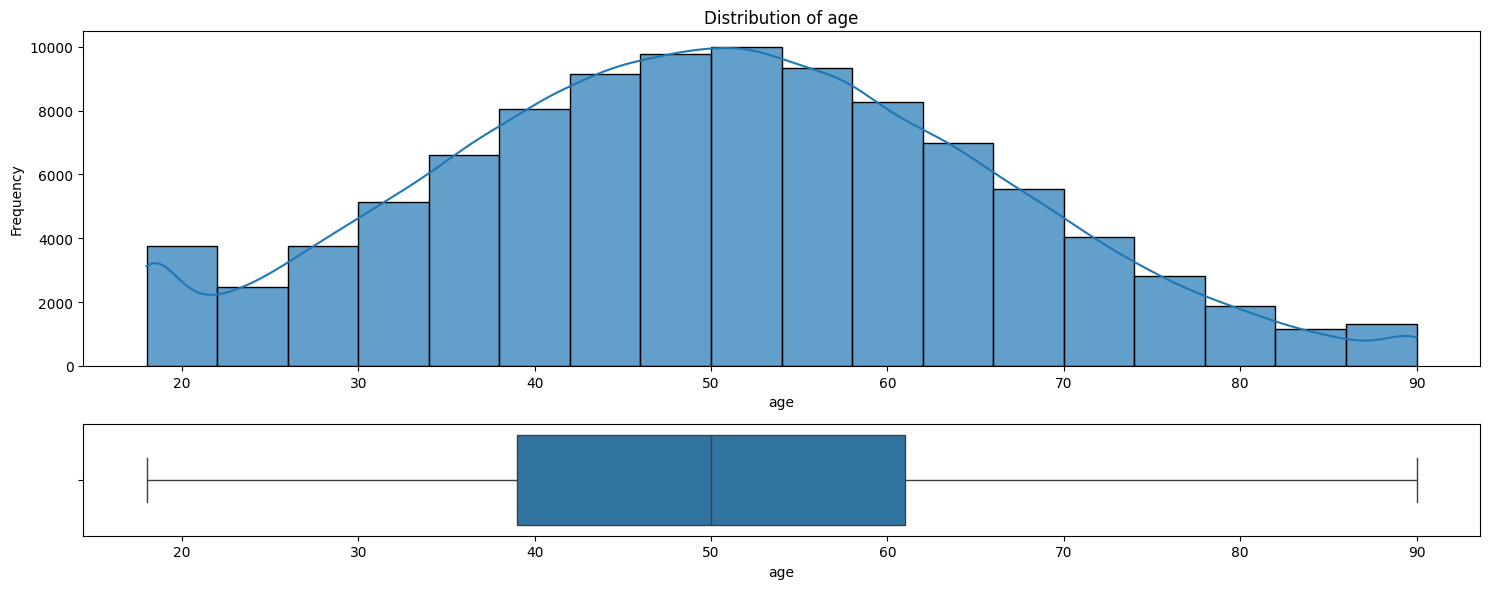


============== Distribution of age by target ==============


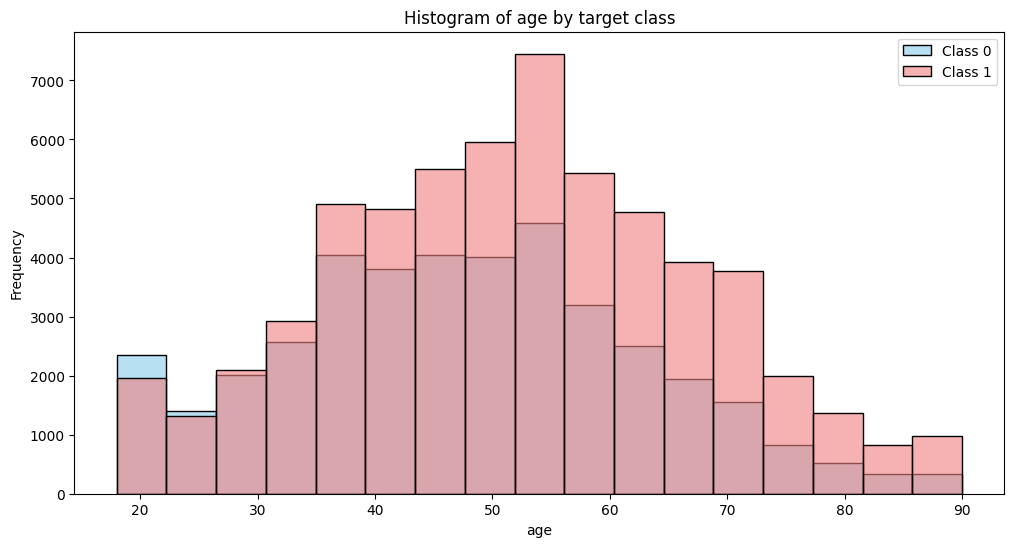


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
age,40002.0,47.488601,15.328775,18.0,37.0,47.0,58.0,90.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
age,59998.0,51.875096,15.54024,18.0,41.0,52.0,63.0,90.0



============== Distribution of feature: physical_activity_minutes_per_week ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
physical_activity_minutes_per_week,100000.0,118.91164,84.409662,0.0,57.0,100.0,160.0,833.0


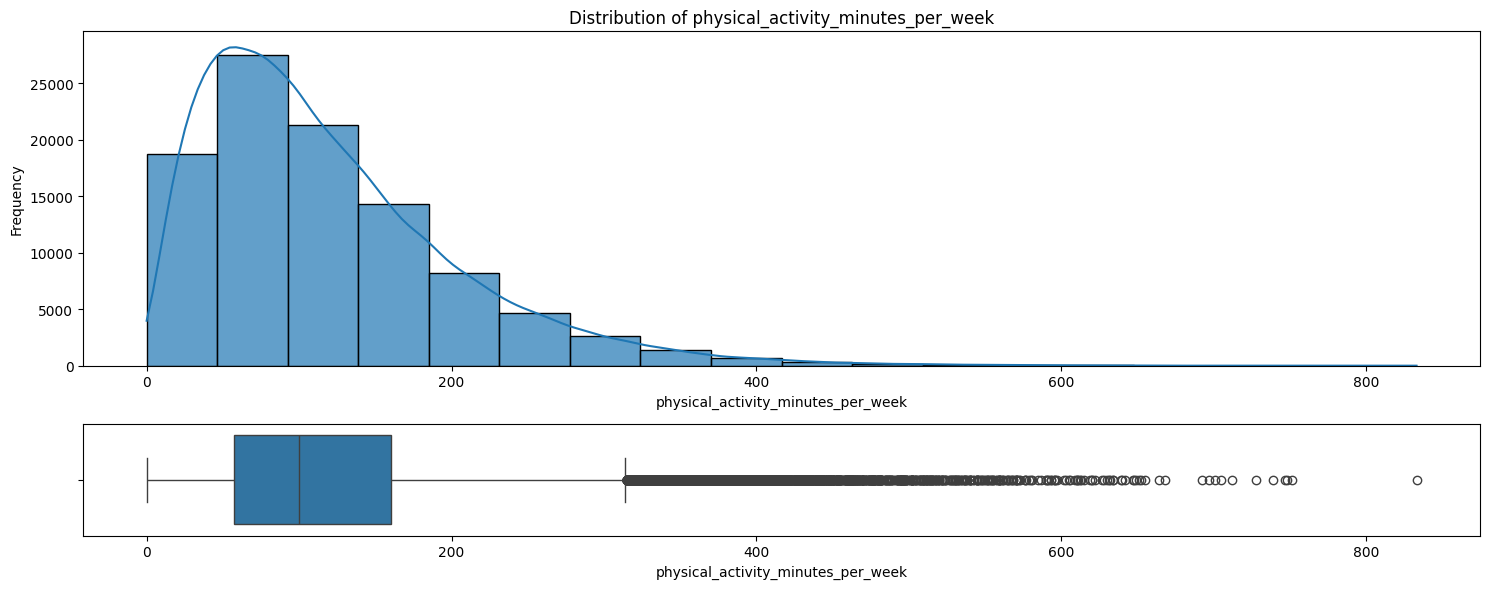


============== Distribution of physical_activity_minutes_per_week by target ==============


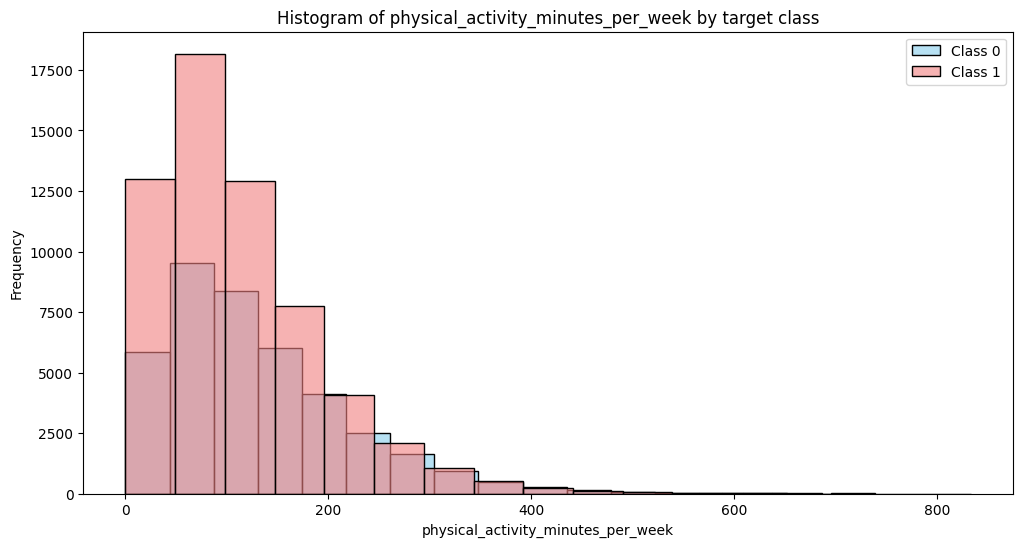


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
physical_activity_minutes_per_week,40002.0,129.329184,89.973008,0.0,62.0,109.0,176.0,739.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
physical_activity_minutes_per_week,59998.0,111.966032,79.735152,0.0,53.0,94.0,151.0,833.0



============== Distribution of feature: diet_score ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
diet_score,100000.0,5.994787,1.780954,0.0,4.8,6.0,7.2,10.0


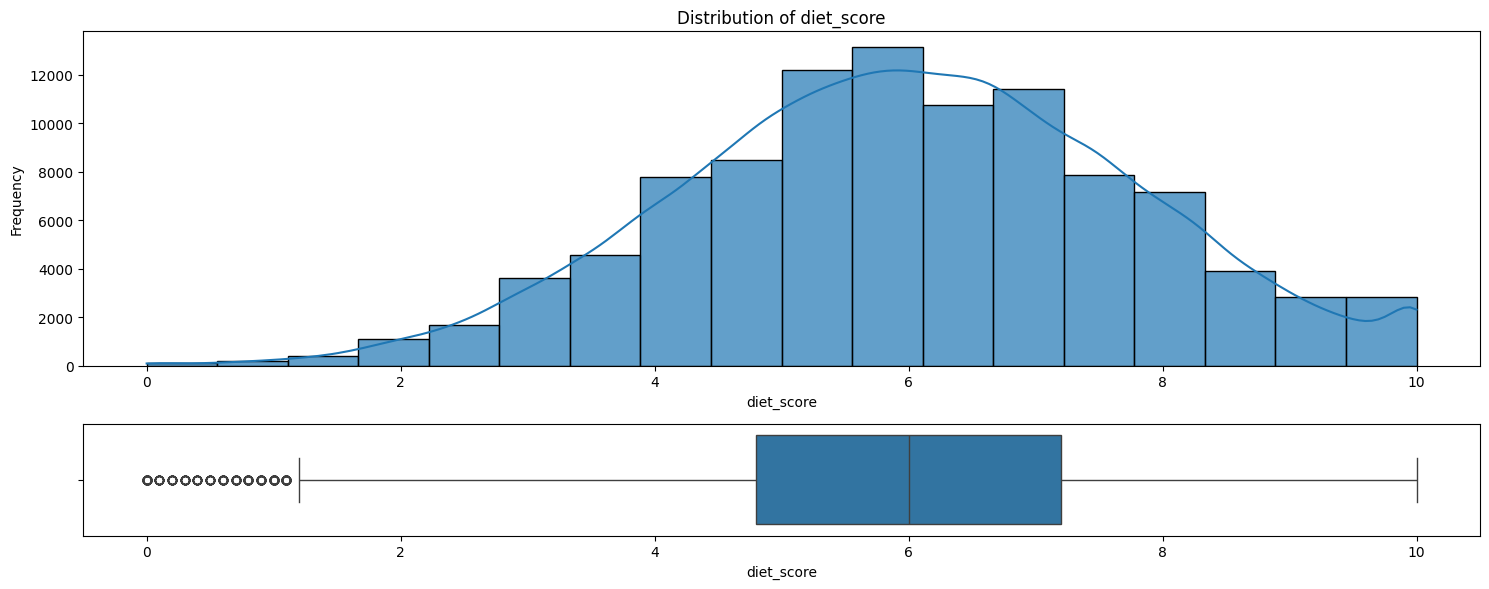


============== Distribution of diet_score by target ==============


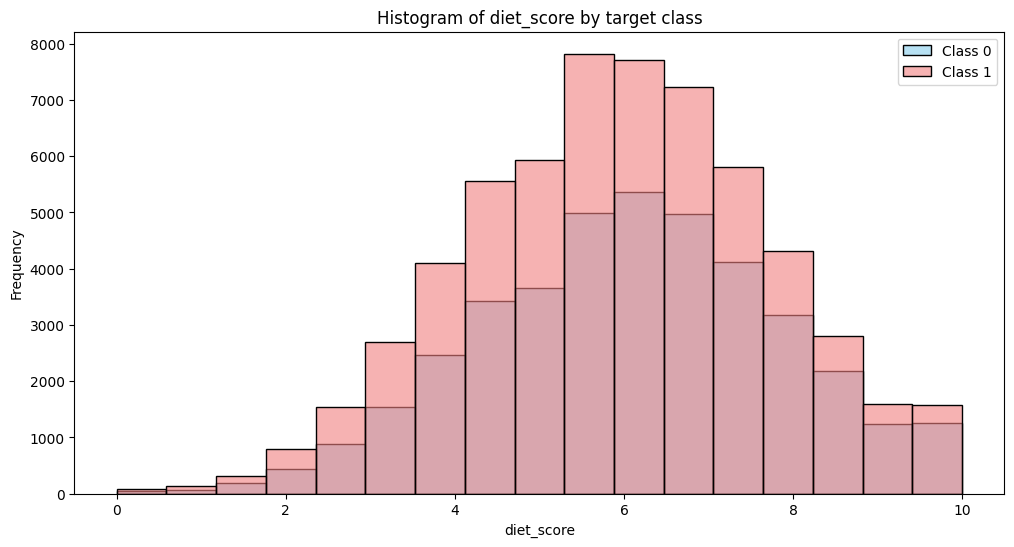


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
diet_score,40002.0,6.091405,1.779164,0.0,4.9,6.1,7.3,10.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
diet_score,59998.0,5.930369,1.779249,0.0,4.7,5.9,7.2,10.0



============== Distribution of feature: sleep_hours_per_day ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
sleep_hours_per_day,100000.0,6.997818,1.094622,3.0,6.3,7.0,7.7,10.0


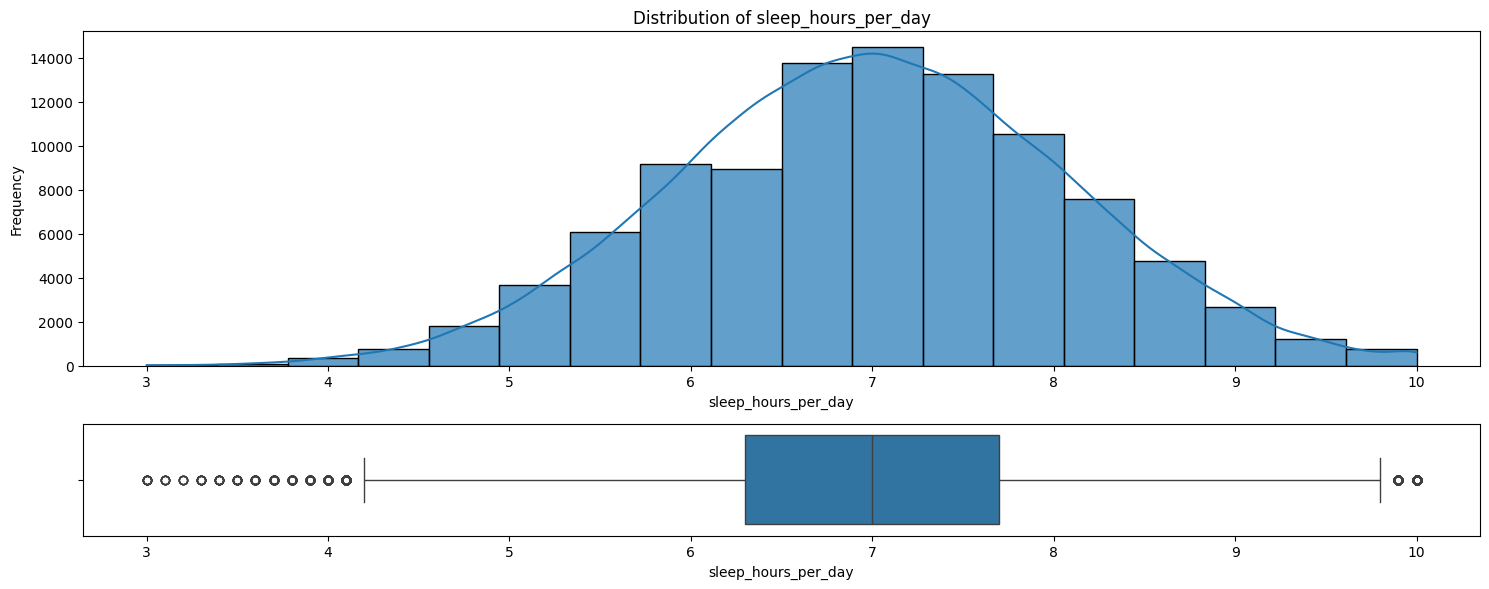


============== Distribution of sleep_hours_per_day by target ==============


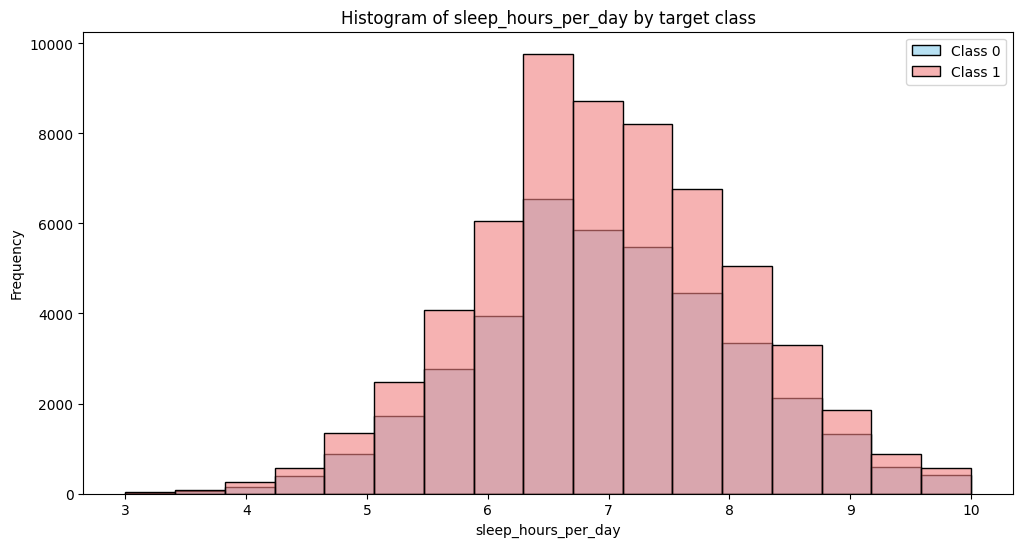


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
sleep_hours_per_day,40002.0,6.998353,1.096839,3.0,6.3,7.0,7.7,10.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
sleep_hours_per_day,59998.0,6.997462,1.093151,3.0,6.3,7.0,7.7,10.0



============== Distribution of feature: screen_time_hours_per_day ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
screen_time_hours_per_day,100000.0,5.996468,2.468406,0.5,4.3,6.0,7.7,16.8


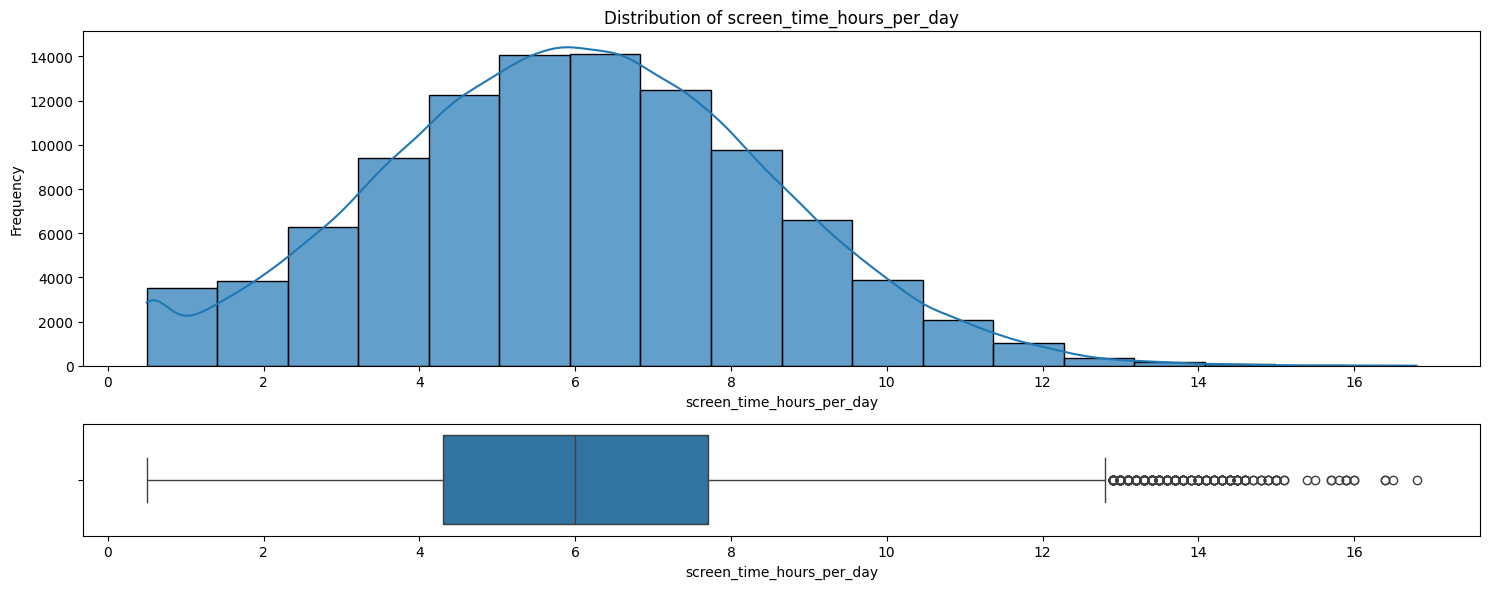


============== Distribution of screen_time_hours_per_day by target ==============


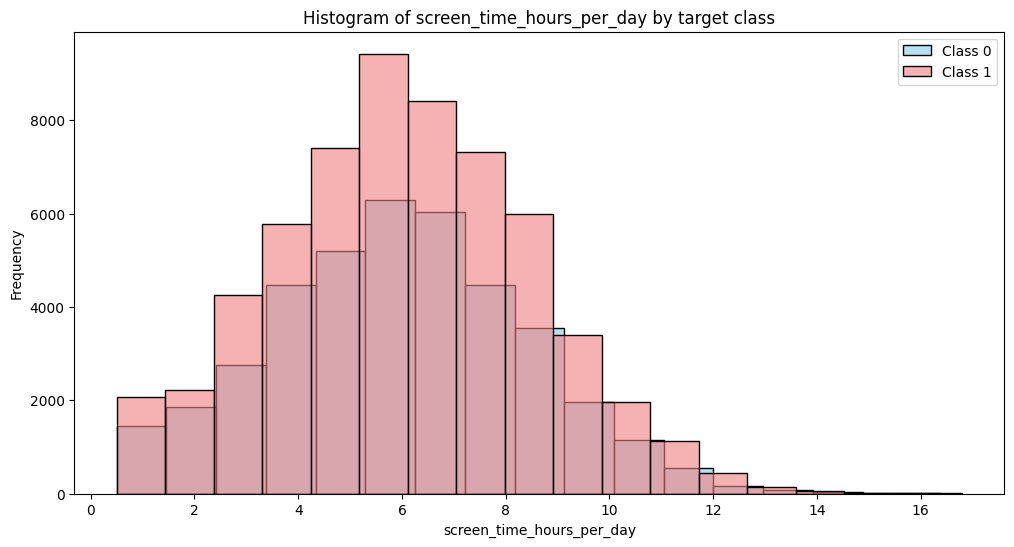


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
screen_time_hours_per_day,40002.0,5.94167,2.469477,0.5,4.2,5.9,7.6,16.8


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
screen_time_hours_per_day,59998.0,6.033003,2.467036,0.5,4.3,6.0,7.7,16.4



============== Distribution of feature: bmi ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
bmi,100000.0,25.612653,3.586705,15.0,23.2,25.6,28.0,39.2


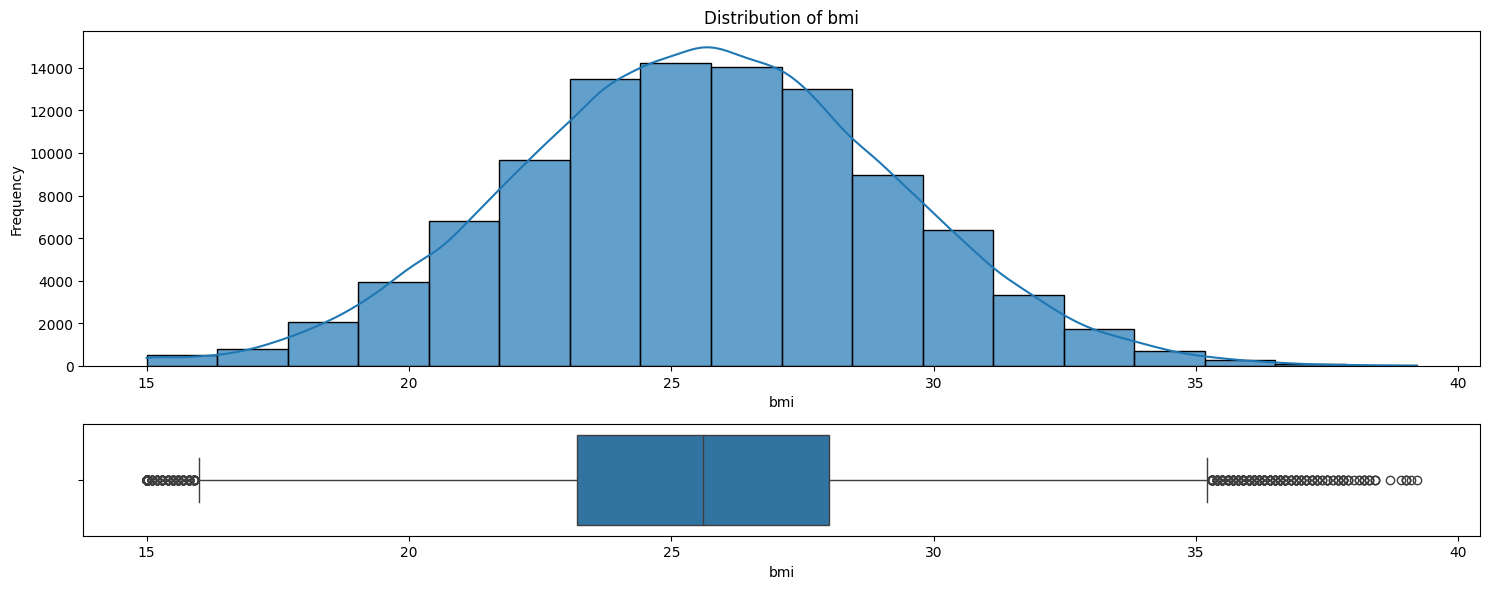


============== Distribution of bmi by target ==============


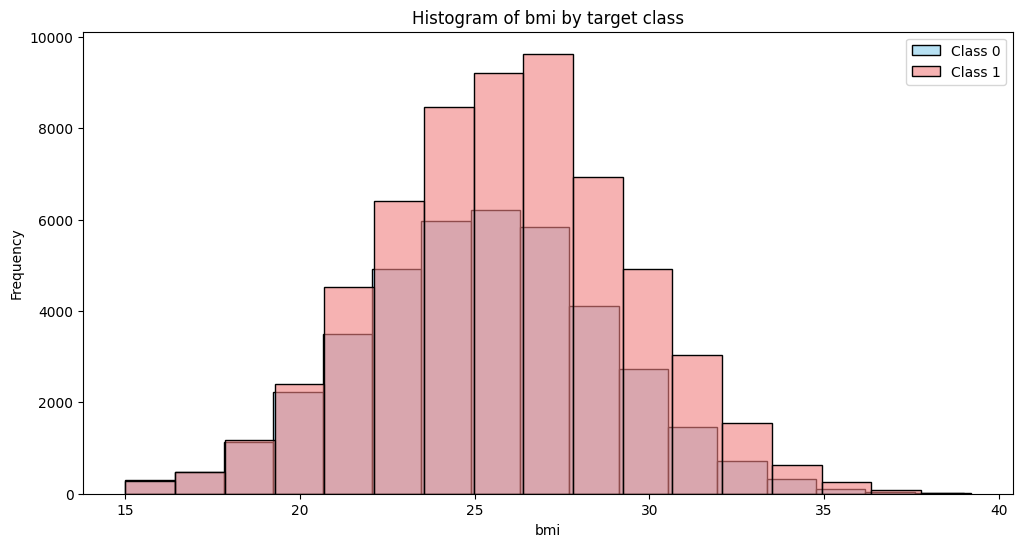


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
bmi,40002.0,25.186321,3.560957,15.0,22.8,25.2,27.6,39.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
bmi,59998.0,25.896898,3.575666,15.0,23.5,25.9,28.3,39.2



============== Distribution of feature: waist_to_hip_ratio ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
waist_to_hip_ratio,100000.0,0.856078,0.046837,0.67,0.82,0.86,0.89,1.06


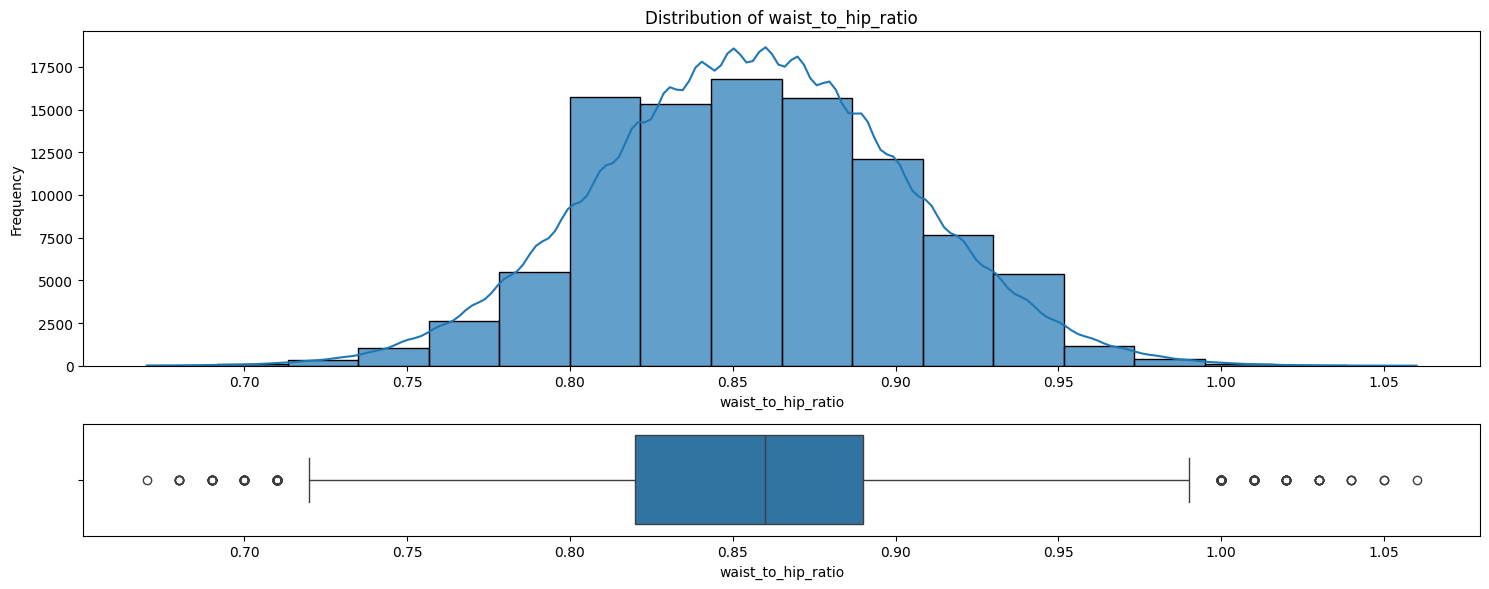


============== Distribution of waist_to_hip_ratio by target ==============


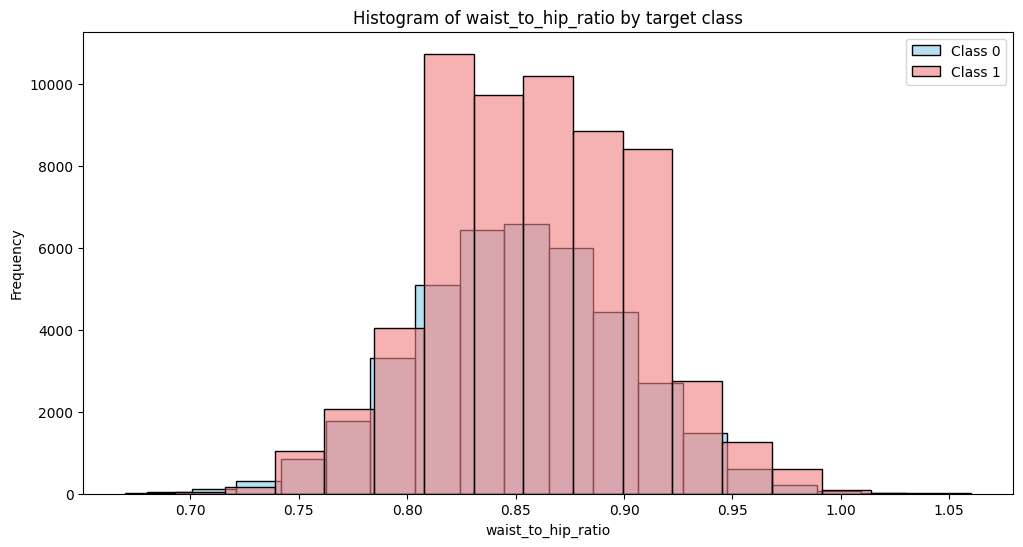


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
waist_to_hip_ratio,40002.0,0.851551,0.046864,0.68,0.82,0.85,0.88,1.03


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
waist_to_hip_ratio,59998.0,0.859096,0.046576,0.67,0.83,0.86,0.89,1.06



============== Distribution of feature: systolic_bp ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
systolic_bp,100000.0,115.79961,14.284073,90.0,106.0,116.0,125.0,179.0


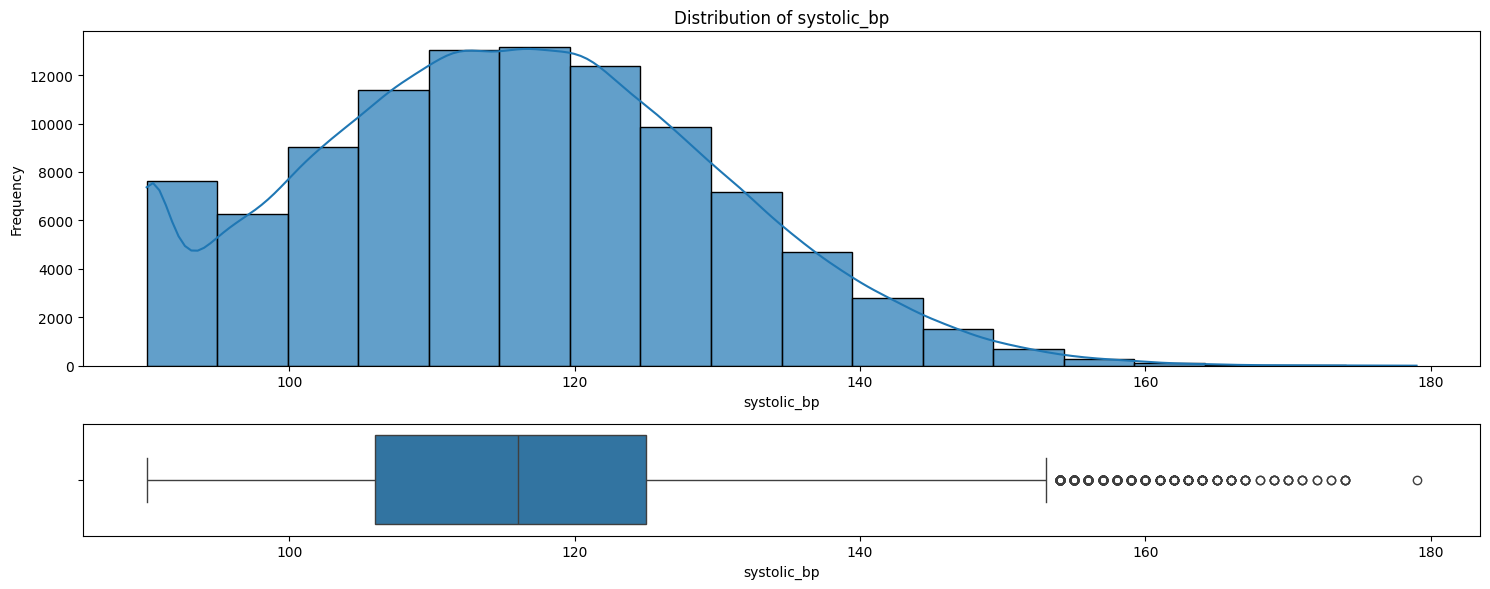


============== Distribution of systolic_bp by target ==============


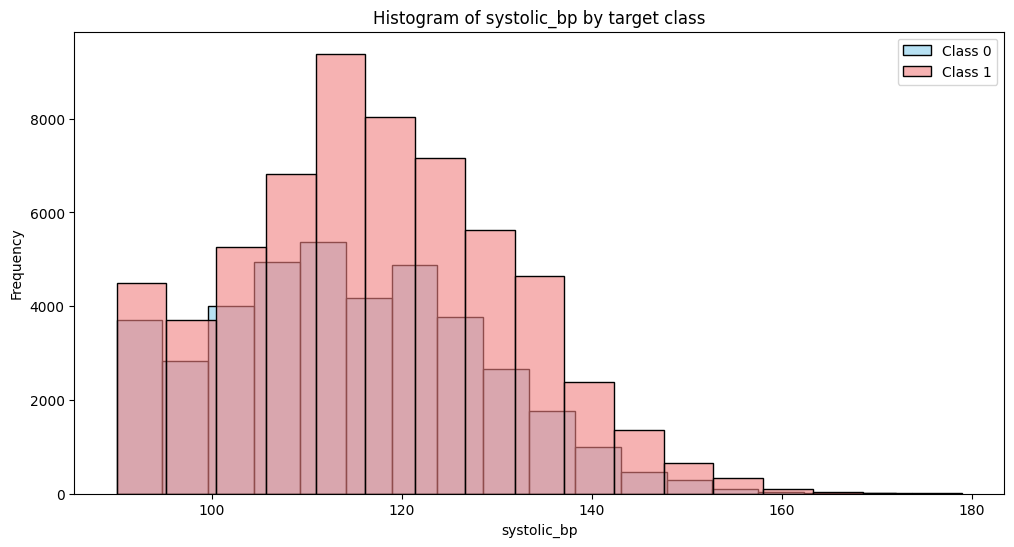


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
systolic_bp,40002.0,114.129319,14.029233,90.0,104.0,114.0,124.0,172.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
systolic_bp,59998.0,116.91323,14.343935,90.0,107.0,117.0,127.0,179.0



============== Distribution of feature: diastolic_bp ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
diastolic_bp,100000.0,75.23249,8.20425,50.0,70.0,75.0,81.0,110.0


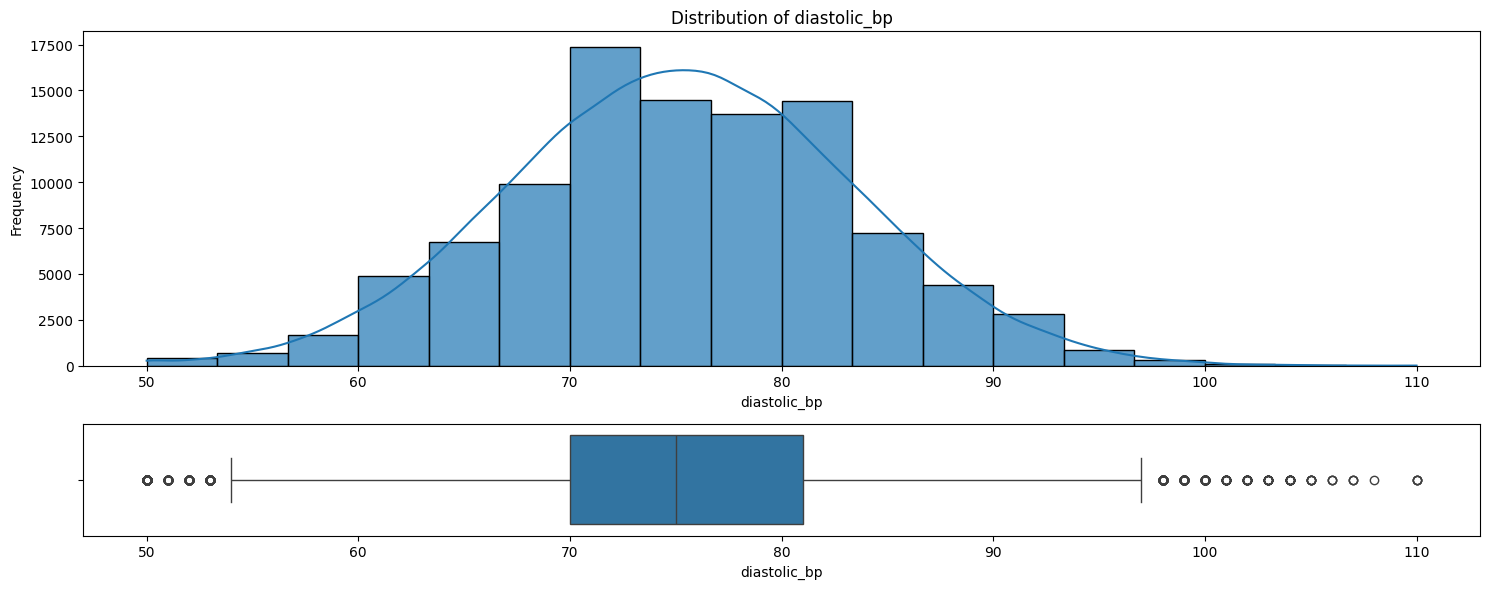


============== Distribution of diastolic_bp by target ==============


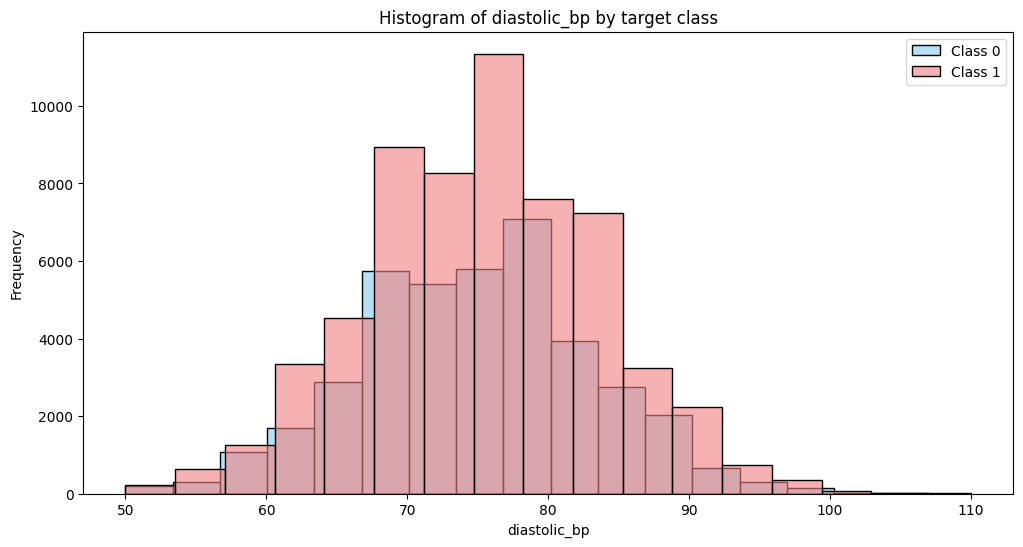


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
diastolic_bp,40002.0,74.874606,8.179887,50.0,69.0,75.0,80.0,107.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
diastolic_bp,59998.0,75.471099,8.211859,50.0,70.0,75.0,81.0,110.0



============== Distribution of feature: heart_rate ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
heart_rate,100000.0,69.63287,8.371954,40.0,64.0,70.0,75.0,105.0


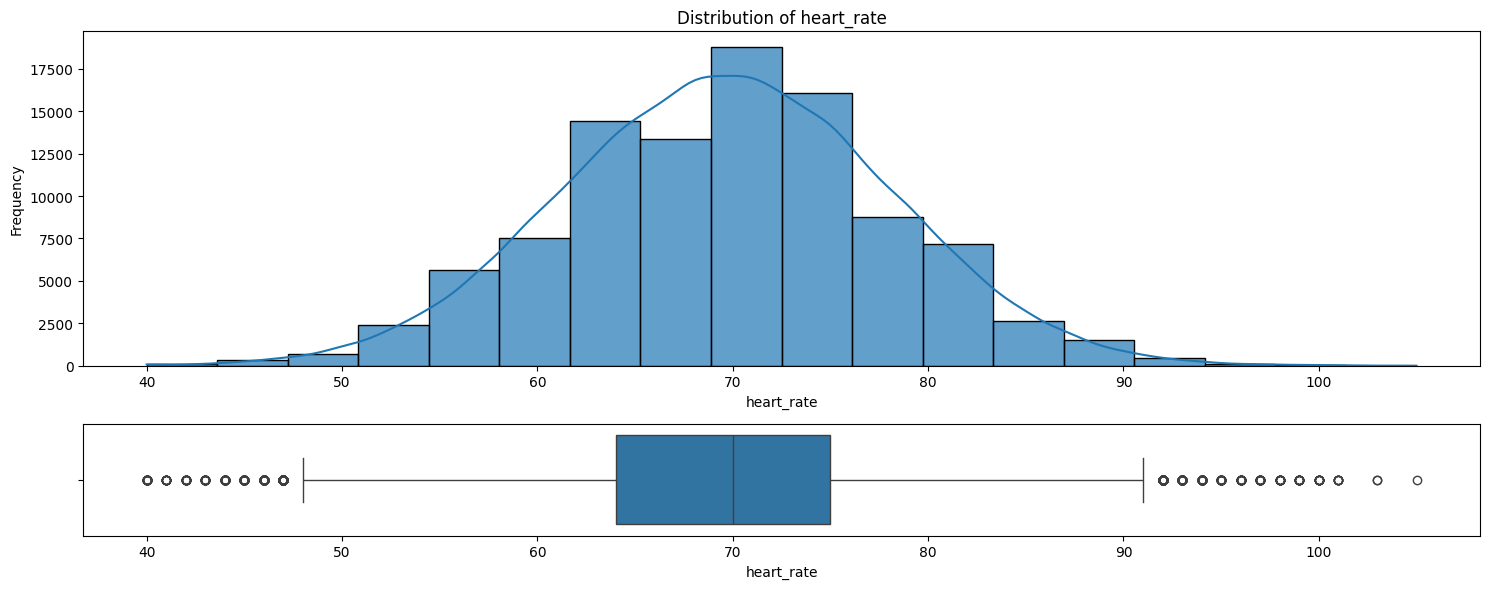


============== Distribution of heart_rate by target ==============


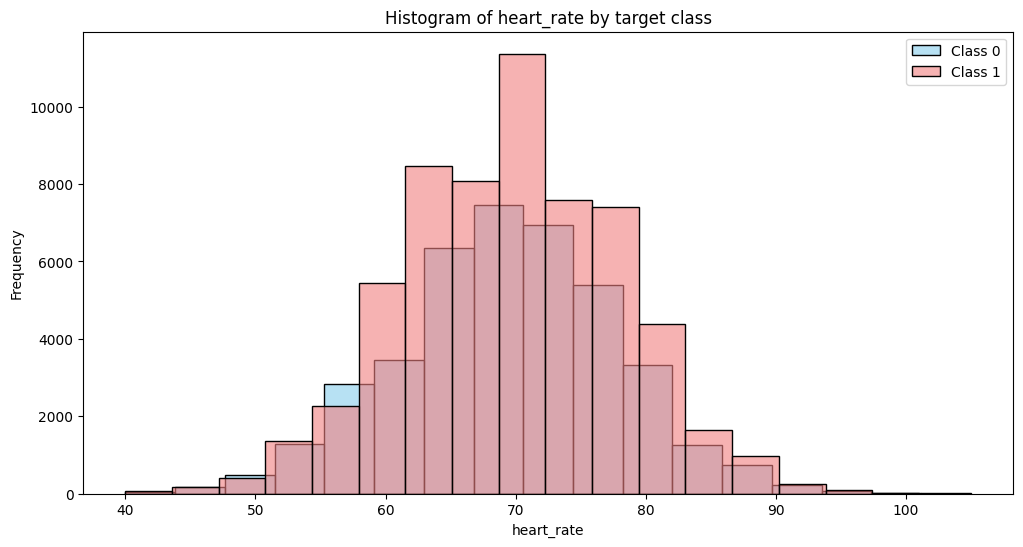


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
heart_rate,40002.0,69.399255,8.394302,40.0,64.0,69.0,75.0,105.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
heart_rate,59998.0,69.788626,8.353461,40.0,64.0,70.0,75.0,101.0



============== Distribution of feature: cholesterol_total ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
cholesterol_total,100000.0,185.97811,32.013005,100.0,164.0,186.0,208.0,318.0


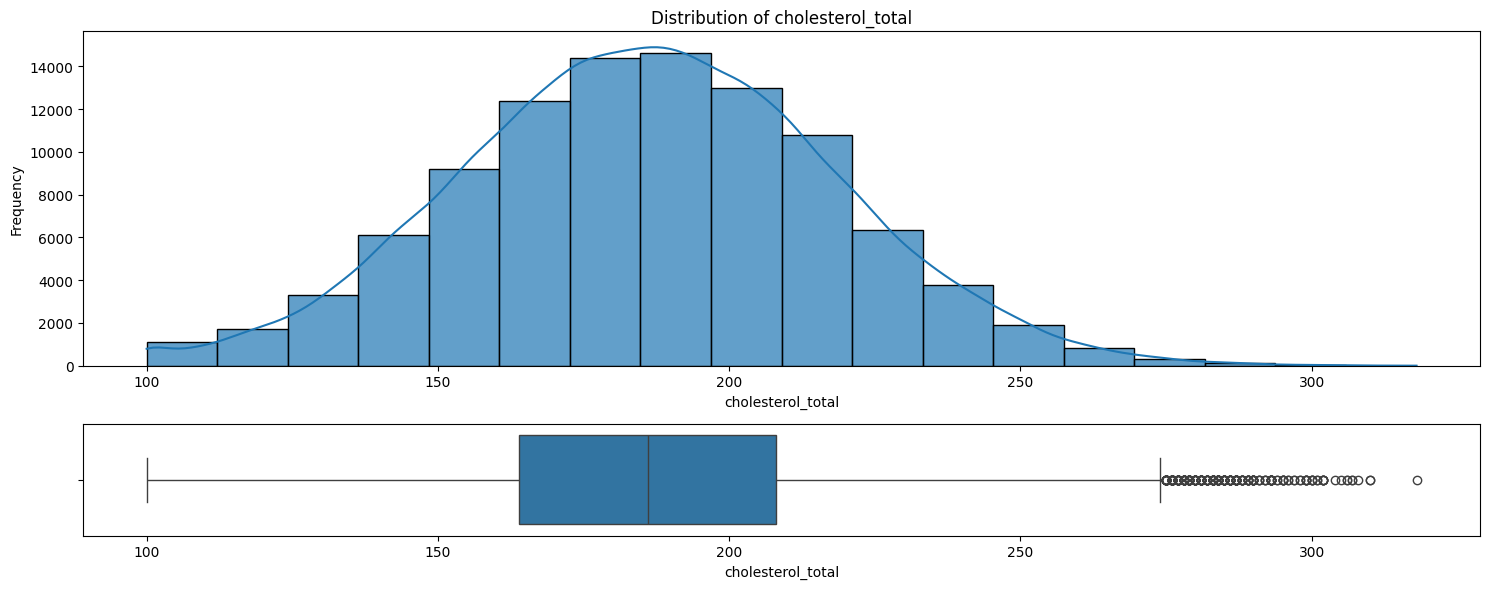


============== Distribution of cholesterol_total by target ==============


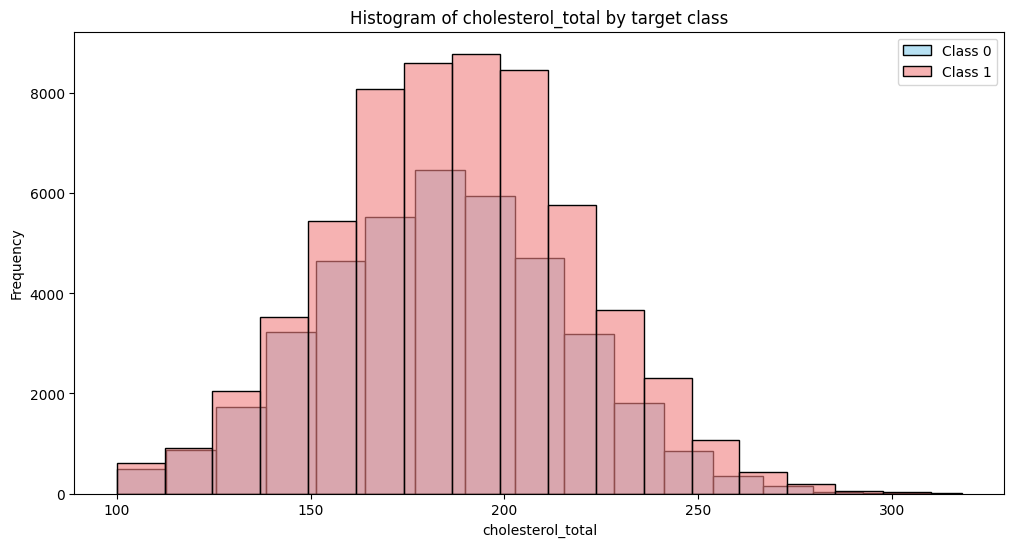


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
cholesterol_total,40002.0,183.697365,31.781603,100.0,162.0,184.0,205.0,318.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
cholesterol_total,59998.0,187.498733,32.076647,100.0,166.0,188.0,209.0,310.0



============== Distribution of feature: hdl_cholesterol ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
hdl_cholesterol,100000.0,54.04279,10.267374,20.0,47.0,54.0,61.0,98.0


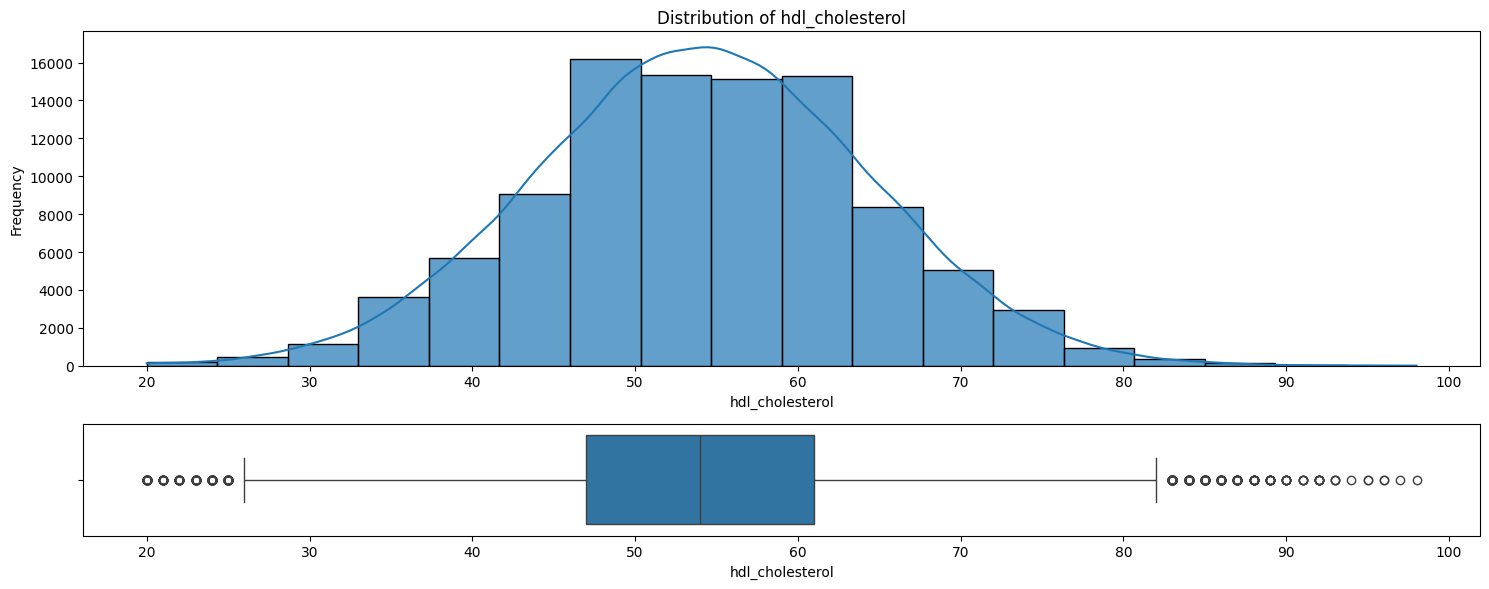


============== Distribution of hdl_cholesterol by target ==============


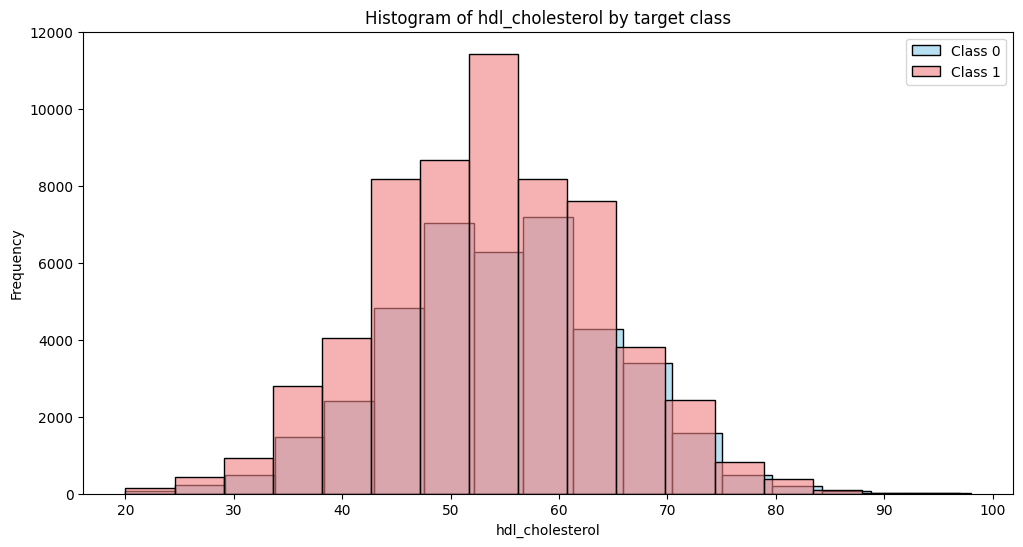


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
hdl_cholesterol,40002.0,54.686941,10.130498,20.0,48.0,55.0,62.0,98.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
hdl_cholesterol,59998.0,53.61332,10.335429,20.0,47.0,54.0,61.0,97.0



============== Distribution of feature: ldl_cholesterol ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
ldl_cholesterol,100000.0,103.00043,33.390256,50.0,78.0,102.0,126.0,263.0


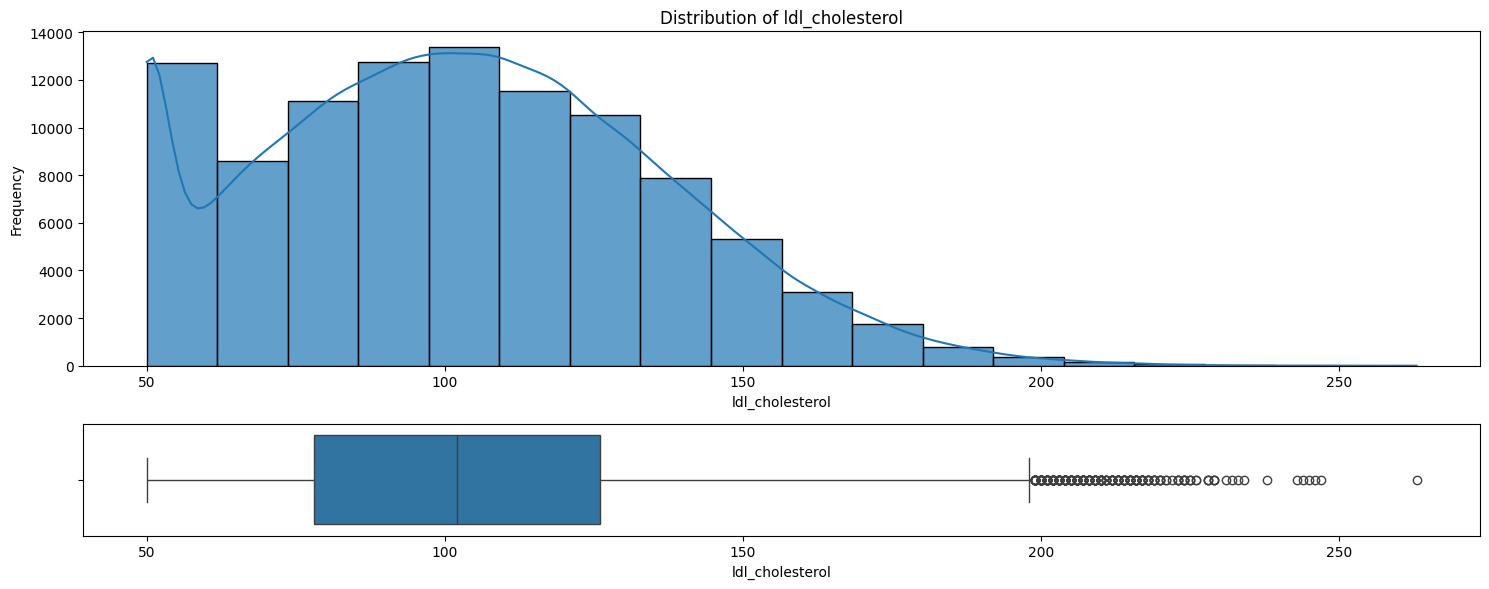


============== Distribution of ldl_cholesterol by target ==============


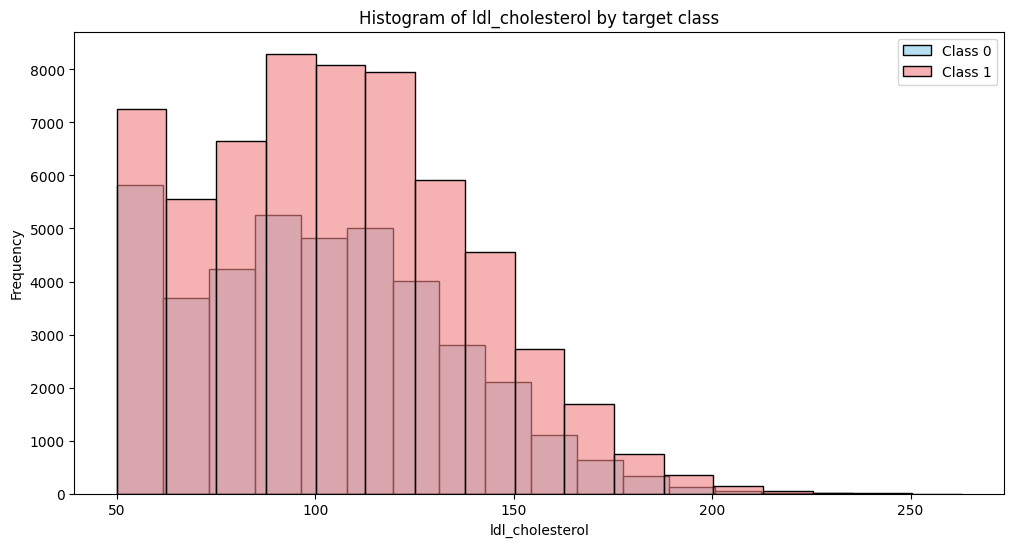


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
ldl_cholesterol,40002.0,100.241213,32.897515,50.0,75.0,99.0,123.0,247.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
ldl_cholesterol,59998.0,104.840061,33.589347,50.0,80.0,104.0,128.0,263.0



============== Distribution of feature: triglycerides ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
triglycerides,100000.0,121.46265,43.372619,30.0,91.0,121.0,151.0,344.0


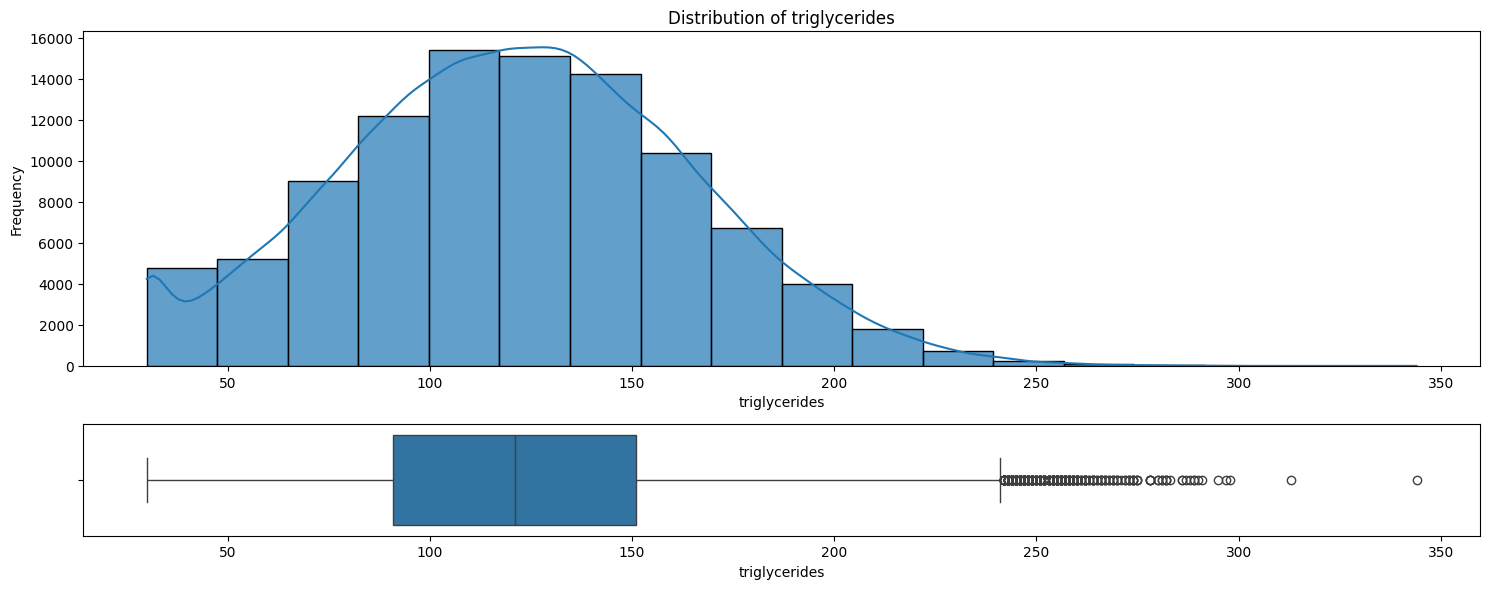


============== Distribution of triglycerides by target ==============


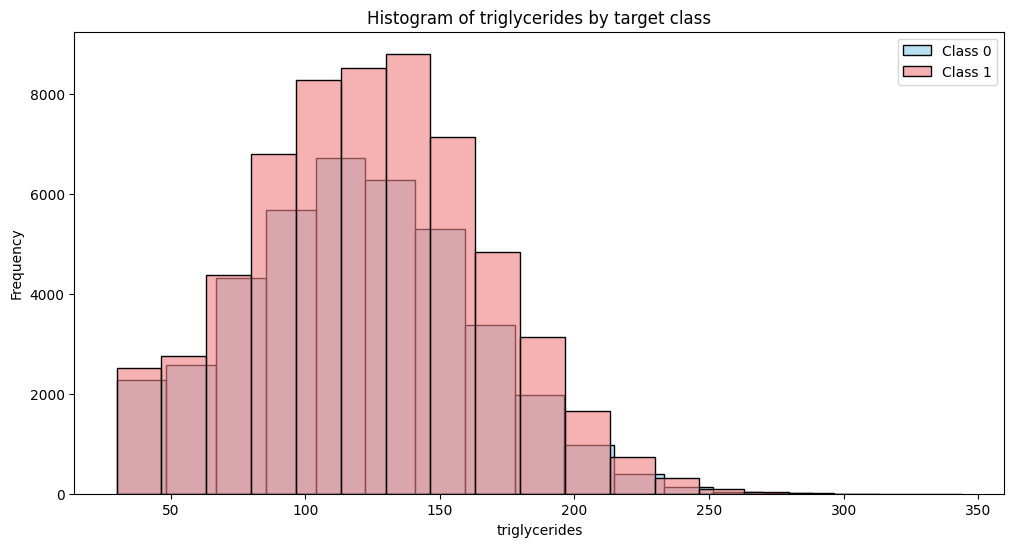


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
triglycerides,40002.0,118.475826,43.098975,30.0,89.0,118.0,148.0,344.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
triglycerides,59998.0,123.454032,43.44051,30.0,93.0,123.0,153.0,313.0



============== Distribution of feature: glucose_fasting ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
glucose_fasting,100000.0,111.11712,13.59561,60.0,102.0,111.0,120.0,172.0


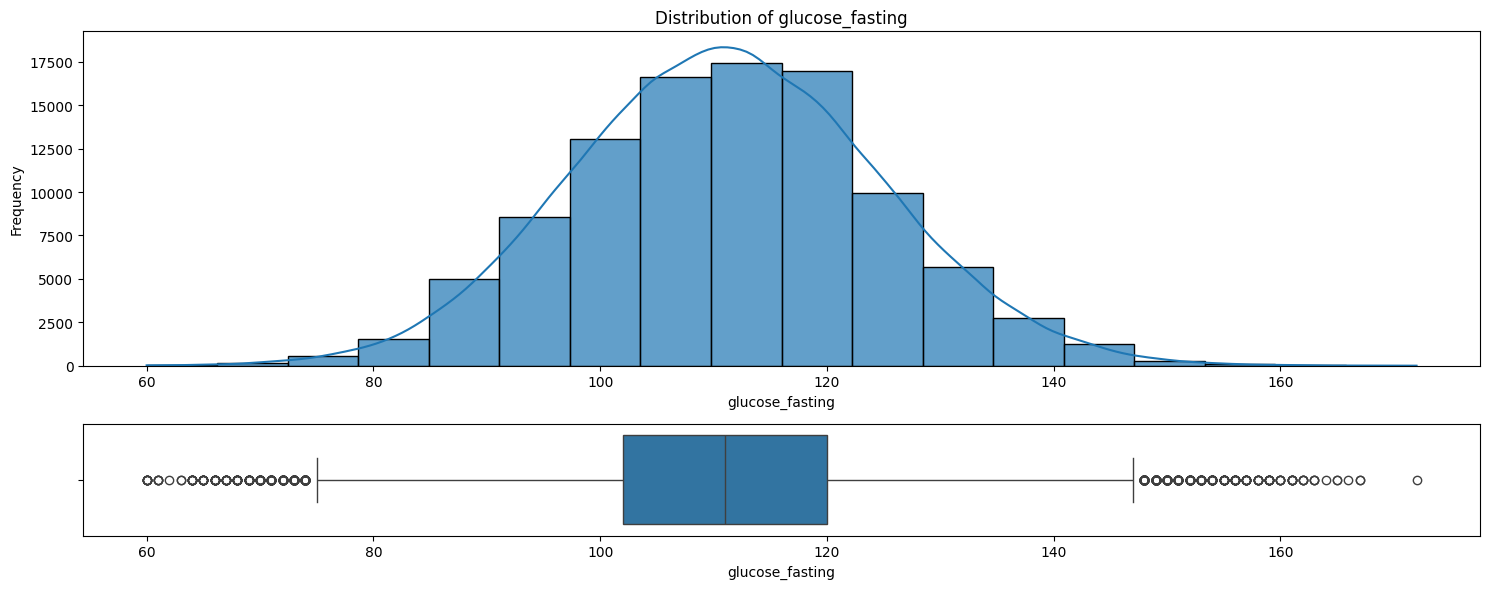


============== Distribution of glucose_fasting by target ==============


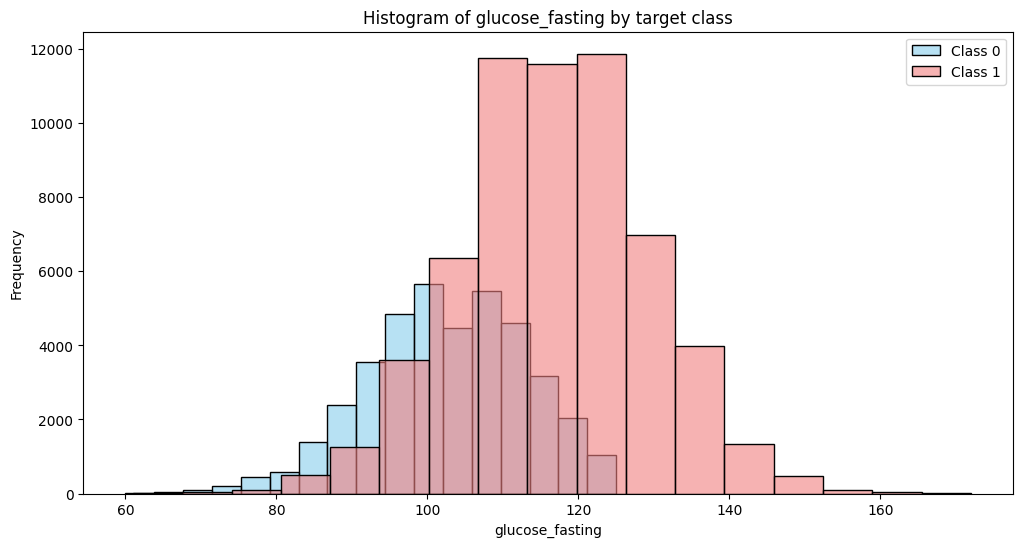


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
glucose_fasting,40002.0,102.610119,10.541229,60.0,96.0,103.0,110.0,125.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
glucose_fasting,59998.0,116.788926,12.392551,61.0,109.0,117.0,125.0,172.0



============== Distribution of feature: glucose_postprandial ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
glucose_postprandial,100000.0,160.03505,30.935472,70.0,139.0,160.0,181.0,287.0


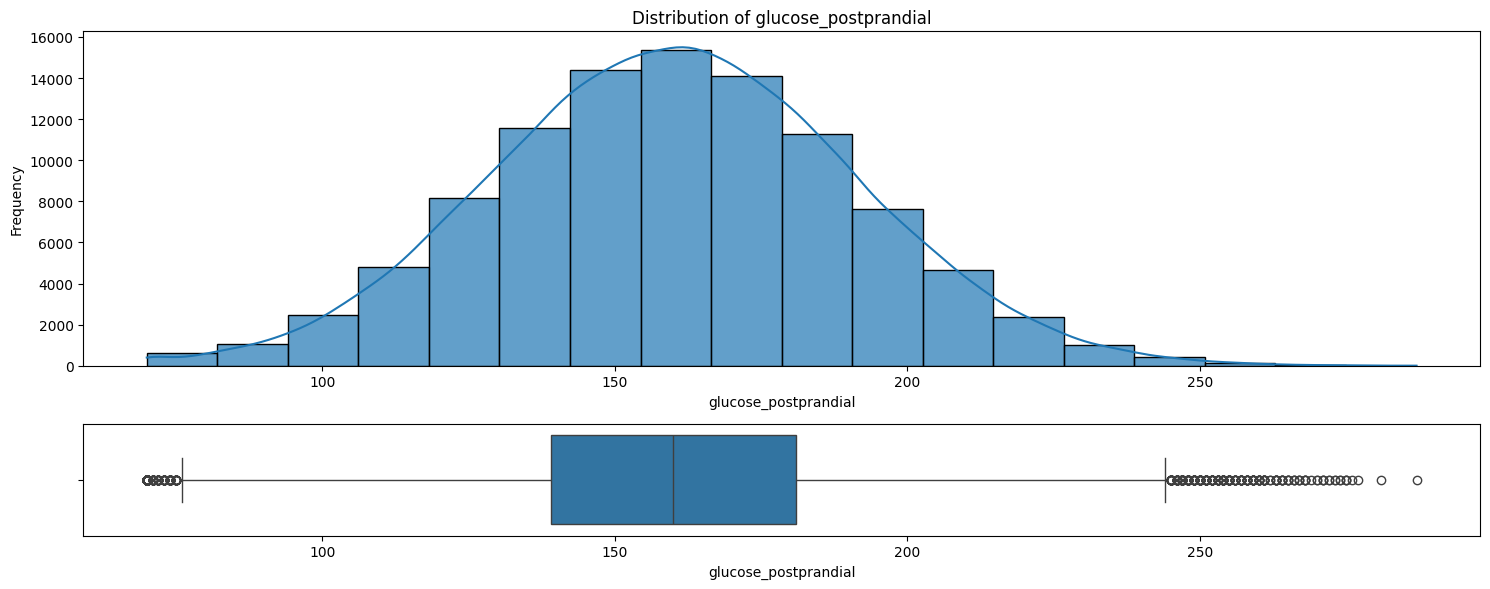


============== Distribution of glucose_postprandial by target ==============


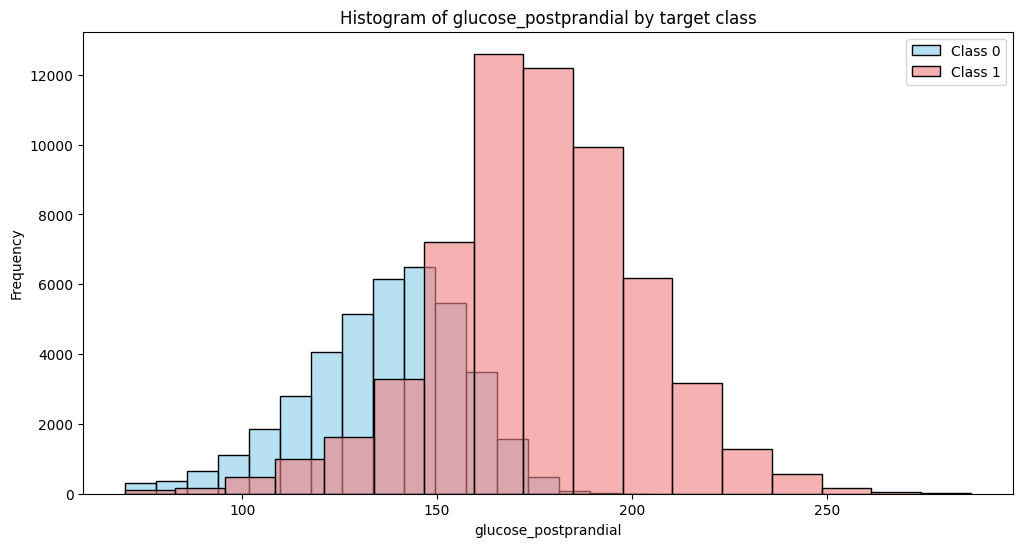


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
glucose_postprandial,40002.0,136.173041,20.466046,70.0,123.0,138.0,151.0,205.0


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
glucose_postprandial,59998.0,175.944381,26.135478,70.0,161.0,176.0,192.0,287.0



============== Distribution of feature: insulin_level ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
insulin_level,100000.0,9.061242,4.95406,2.0,5.09,8.79,12.45,32.22


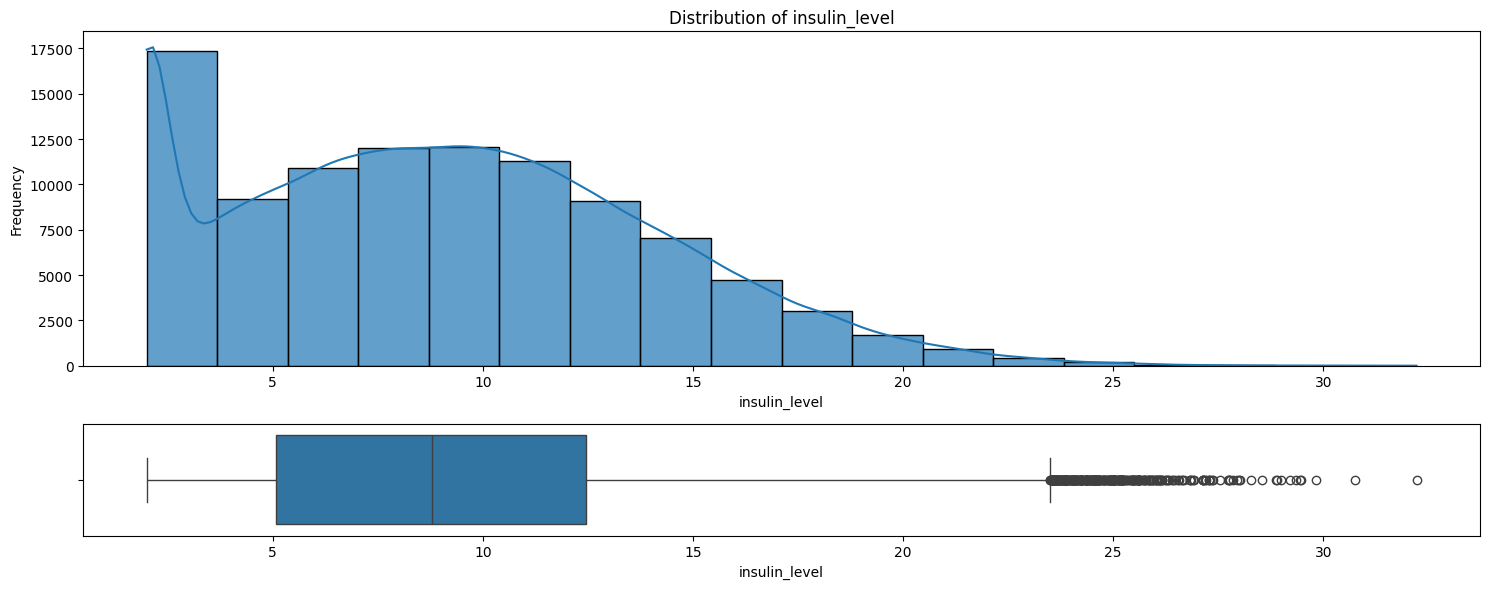


============== Distribution of insulin_level by target ==============


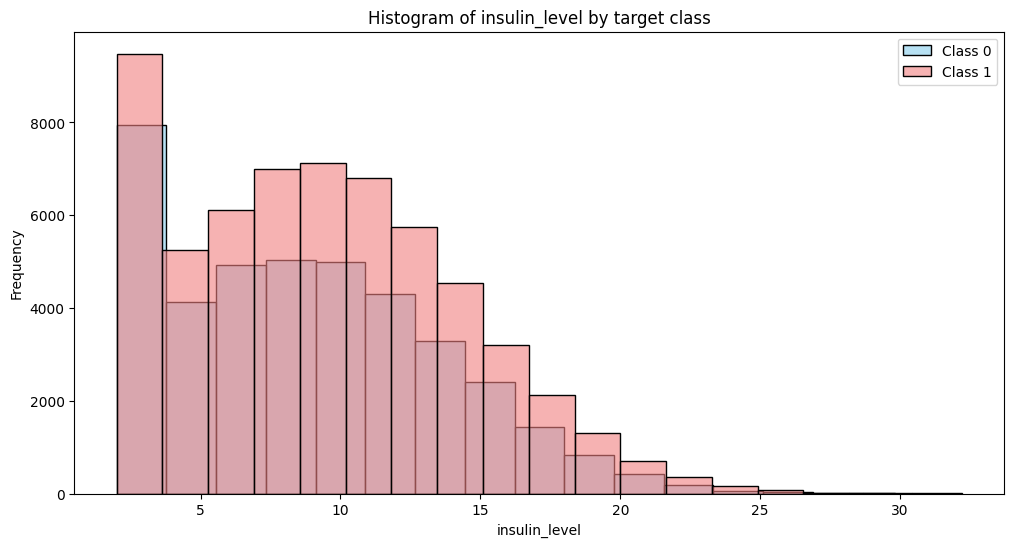


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
insulin_level,40002.0,8.711073,4.887315,2.0,4.7,8.4,12.06,32.22


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
insulin_level,59998.0,9.294708,4.984455,2.0,5.36,9.05,12.7,29.82



============== Distribution of feature: hba1c ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
hba1c,100000.0,6.520776,0.813921,4.0,5.97,6.52,7.07,9.8


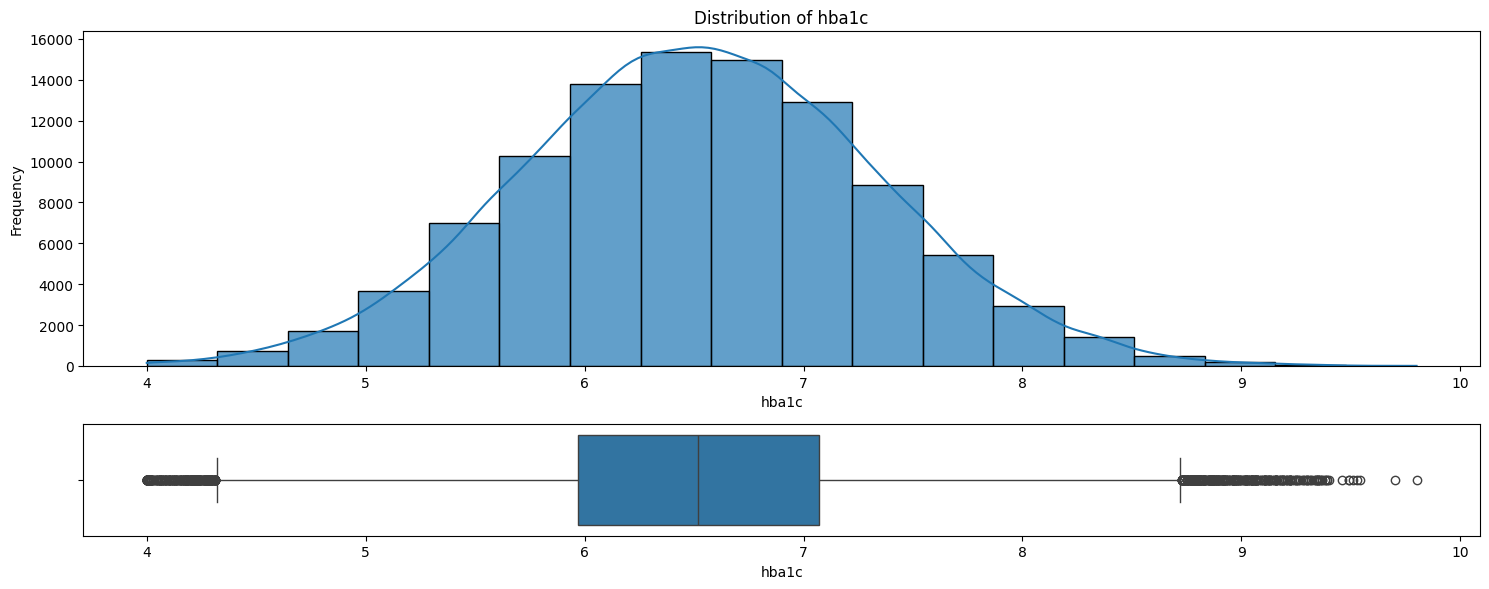


============== Distribution of hba1c by target ==============


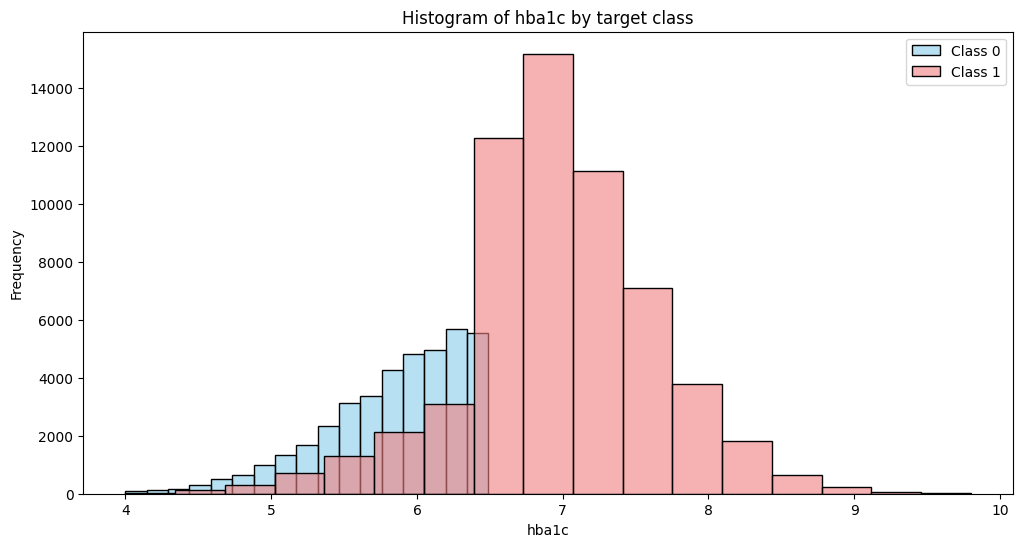


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
hba1c,40002.0,5.843554,0.481845,4.0,5.56,5.94,6.23,6.49


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
hba1c,59998.0,6.972295,0.663103,4.0,6.62,6.95,7.37,9.8



============== Distribution of feature: diabetes_risk_score ==============

Statistics


,count,mean,std,min,25%,50%,75%,max
diabetes_risk_score,100000.0,30.222362,9.061505,2.7,23.8,29.0,35.6,67.2


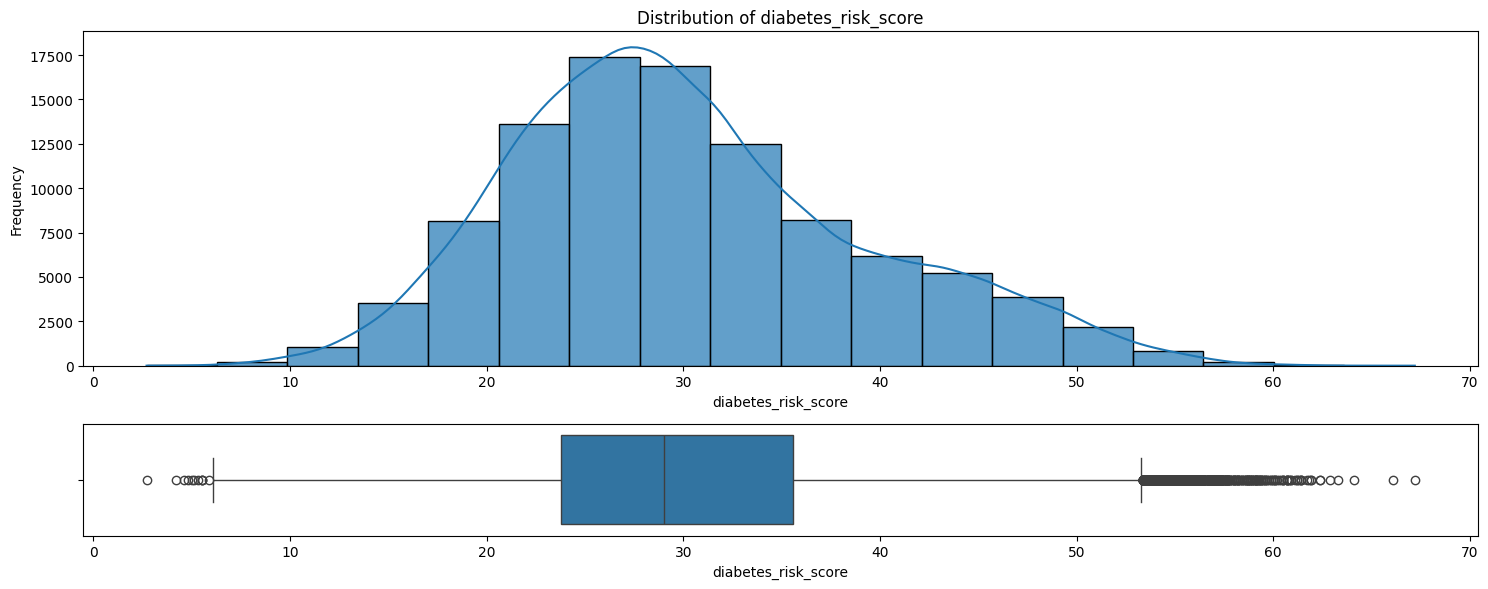


============== Distribution of diabetes_risk_score by target ==============


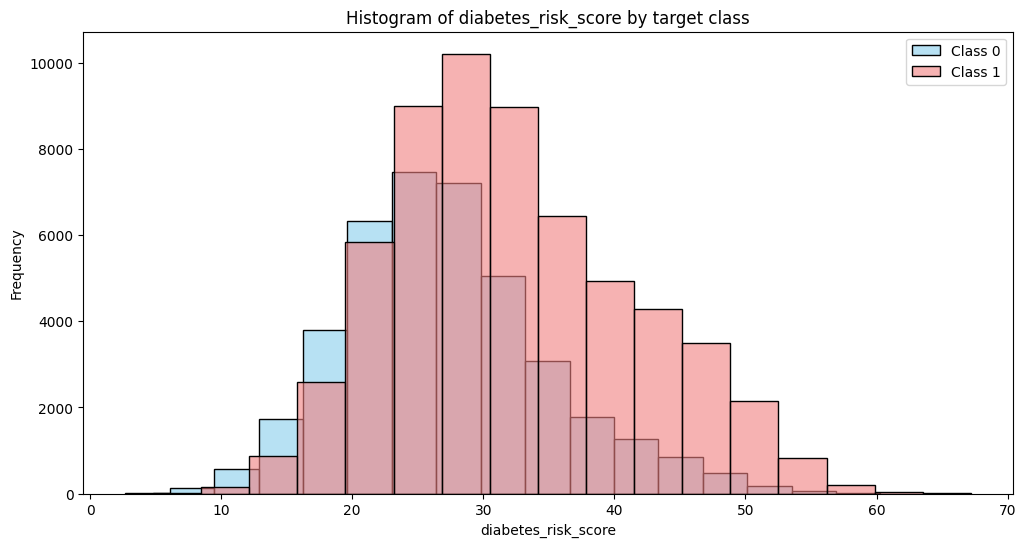


Statistics by class:
Class 0 (n=40002):


,count,mean,std,min,25%,50%,75%,max
diabetes_risk_score,40002.0,27.145025,7.830614,2.7,21.8,26.4,31.5,60.3


Class 1 (n=59998):


,count,mean,std,min,25%,50%,75%,max
diabetes_risk_score,59998.0,32.274091,9.243983,4.8,25.5,31.0,38.5,67.2


In [15]:
# Let's analyse the continuous values

for col in num_cols:
    plot_density_and_boxplot(df, col, target_col='diagnosed_diabetes')

**Observations:**
- All continuous features show log-normal distributions. However, some might need to be log-transformed for linear models.

- Some features show no difference in the mean value across the target valuable. I'll сheck the correlation to see if they can be removed from the dataset.

All correlations with diagnosed_diabetes:


diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
diabetes_risk_score                   0.277300
age                                   0.137713
bmi                                   0.097057
systolic_bp                           0.095481
waist_to_hip_ratio                    0.078918
ldl_cholesterol                       0.067475
cholesterol_total                     0.058173
insulin_level                         0.057715
triglycerides                         0.056230
diastolic_bp                          0.035619
heart_rate                            0.022785
screen_time_hours_per_day             0.018127
sleep_hours_per_day                  -0.000399
diet_score                           -0.044298
hdl_cholesterol                      -0.051227
physical_activity_minutes_per_week   -0.100774
Name: diagnosed_diabetes, dtype: float64

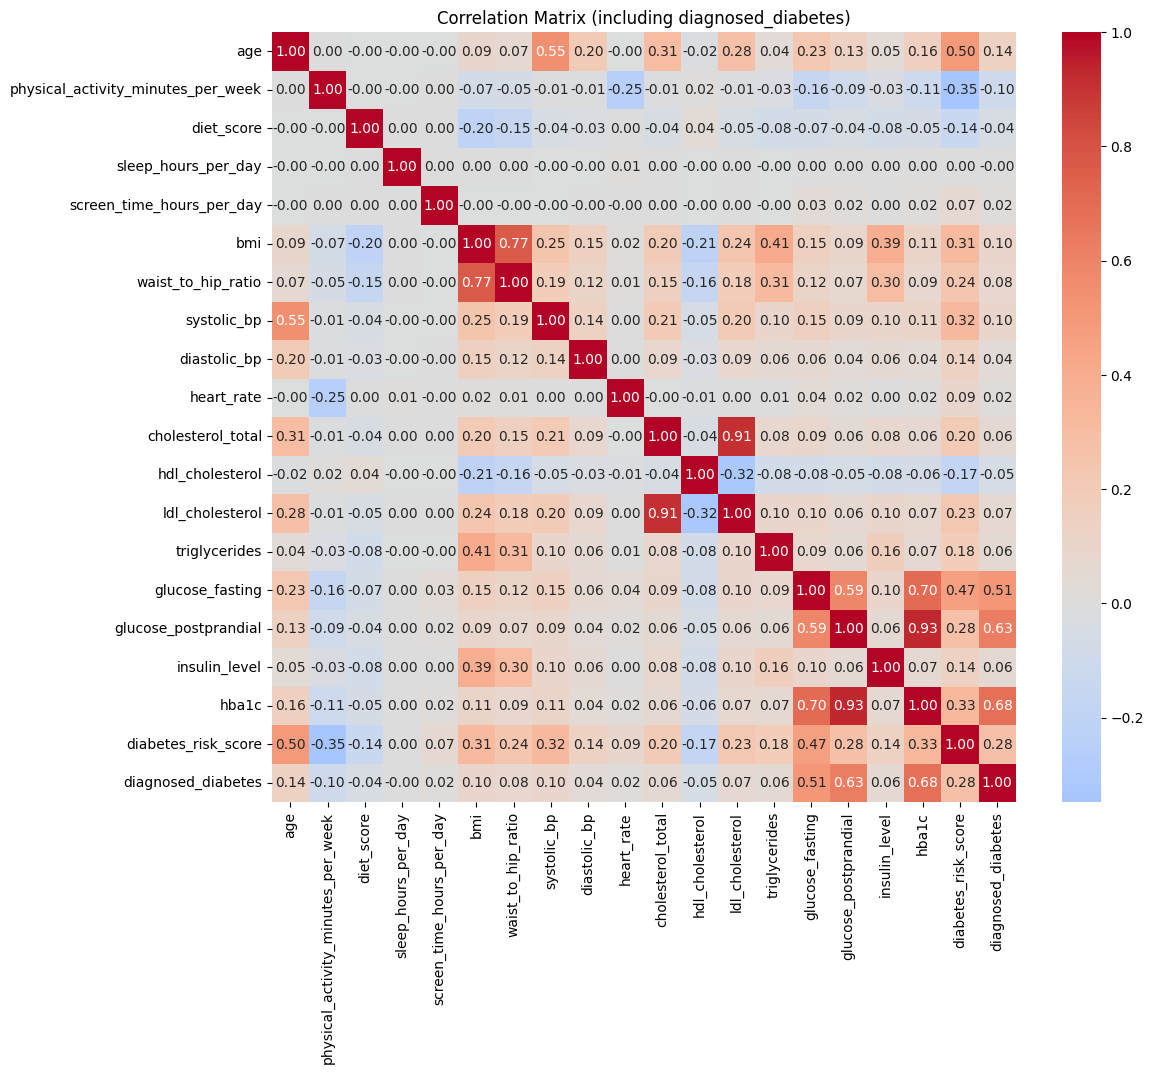

In [ ]:
all_numeric_cols = num_cols + ['diagnosed_diabetes']
corr_matrix = df[all_numeric_cols].corr()

# Correlation with target
target_corrs = corr_matrix['diagnosed_diabetes'].sort_values(ascending=False)

print("All correlations with diagnosed_diabetes:")
display(target_corrs)

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Correlation Matrix (including diagnosed_diabetes)')
plt.show()

**Observations:**

- Some features show very weak correlation with the target variable.

- Also, there are pairs of highly-correlated features, I'll remove them as well.

## Removing unnecessary numeric features

In [ ]:
# Features to remove

# no correlation
weak_features = ['sleep_hours_per_day', 'screen_time_hours_per_day', 
                 'diet_score', 'heart_rate', 'diastolic_bp']

# strong correlation between features, keep only one in each pair
redundant_features = ['waist_to_hip_ratio', 'glucose_postprandial', 'cholesterol_total']


all_to_remove = weak_features + redundant_features
df_clean_1 = df.drop(columns=all_to_remove)
df_clean_1.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,family_history_diabetes,...,systolic_bp,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,0,...,134,41,160,145,136,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,0,...,129,55,50,30,93,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,1,...,115,66,99,36,118,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,0,...,120,50,79,140,139,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,0,...,92,52,125,160,137,12.74,7.20,23.5,Type 2,1


## Categoric Features

In [ ]:
# First let's make alcohol_consumption_per_week have fewer categories

round(df.groupby('alcohol_consumption_per_week')['diagnosed_diabetes'].mean(), 2)

alcohol_consumption_per_week
0     0.60
1     0.60
2     0.60
3     0.60
4     0.61
5     0.59
6     0.61
7     0.59
8     0.53
9     0.46
10    0.50
Name: diagnosed_diabetes, dtype: float64

In [ ]:
df_clean_1['alcohol_group'] = pd.cut(df_clean_1['alcohol_consumption_per_week'], 
                            bins=[-1, 2, 7, 10], 
                            labels=['Low', 'Medium', 'High'])

In [ ]:
cat_features_ = df.select_dtypes(include='object').columns.tolist()
cat_features = cat_features_ + ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'alcohol_group']

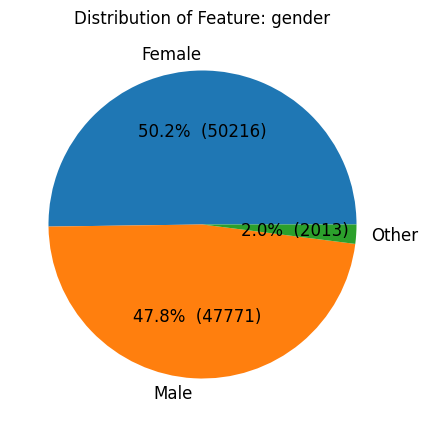

Number of unique values: 3

Distribution of gender by Target Variable


gender
Female    0.60
Male      0.60
Other     0.62
Name: diagnosed_diabetes, dtype: float64

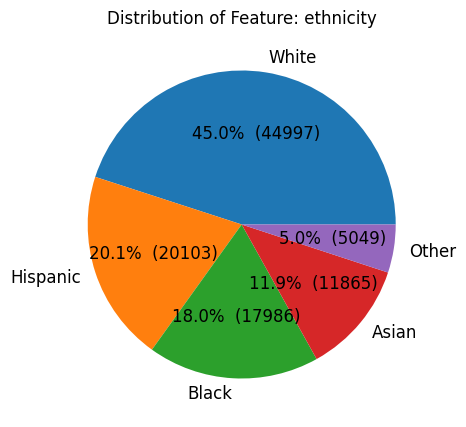

Number of unique values: 5

Distribution of ethnicity by Target Variable


ethnicity
Asian       0.60
Black       0.60
Hispanic    0.59
Other       0.61
White       0.60
Name: diagnosed_diabetes, dtype: float64

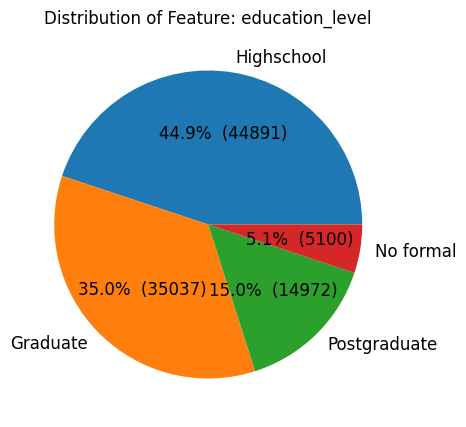

Number of unique values: 4

Distribution of education_level by Target Variable


education_level
Graduate        0.60
Highschool      0.60
No formal       0.60
Postgraduate    0.59
Name: diagnosed_diabetes, dtype: float64

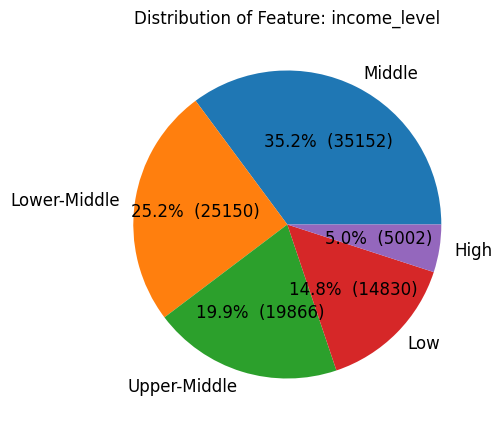

Number of unique values: 5

Distribution of income_level by Target Variable


income_level
High            0.61
Low             0.60
Lower-Middle    0.60
Middle          0.60
Upper-Middle    0.60
Name: diagnosed_diabetes, dtype: float64

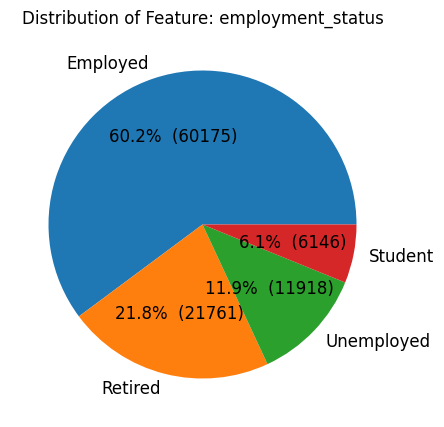

Number of unique values: 4

Distribution of employment_status by Target Variable


employment_status
Employed      0.6
Retired       0.6
Student       0.6
Unemployed    0.6
Name: diagnosed_diabetes, dtype: float64

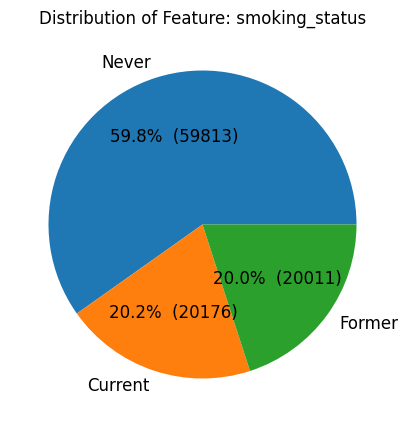

Number of unique values: 3

Distribution of smoking_status by Target Variable


smoking_status
Current    0.6
Former     0.6
Never      0.6
Name: diagnosed_diabetes, dtype: float64

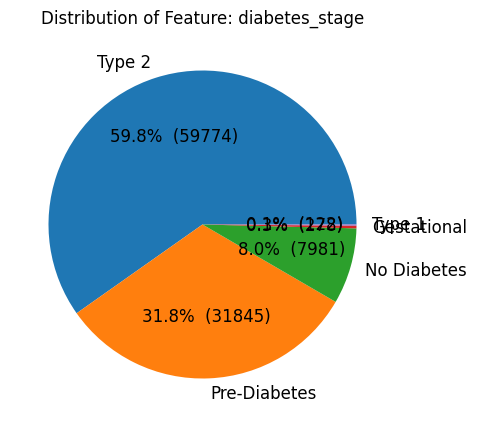

Number of unique values: 5

Distribution of diabetes_stage by Target Variable


diabetes_stage
Gestational     0.57
No Diabetes     0.00
Pre-Diabetes    0.00
Type 1          0.54
Type 2          1.00
Name: diagnosed_diabetes, dtype: float64

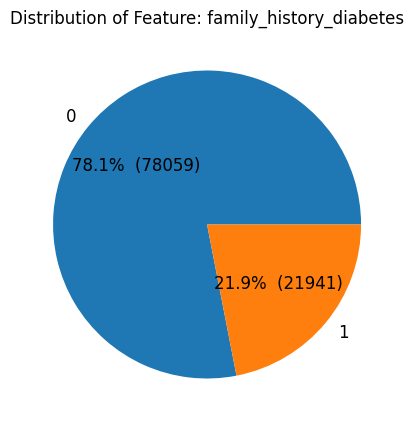

Number of unique values: 2

Distribution of family_history_diabetes by Target Variable


family_history_diabetes
0    0.55
1    0.78
Name: diagnosed_diabetes, dtype: float64

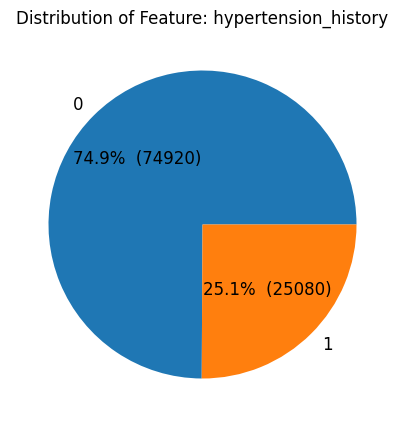

Number of unique values: 2

Distribution of hypertension_history by Target Variable


hypertension_history
0    0.59
1    0.62
Name: diagnosed_diabetes, dtype: float64

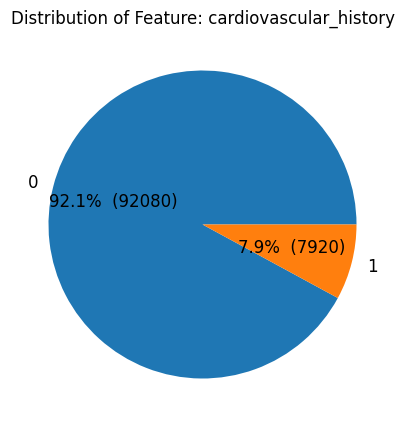

Number of unique values: 2

Distribution of cardiovascular_history by Target Variable


cardiovascular_history
0    0.60
1    0.65
Name: diagnosed_diabetes, dtype: float64

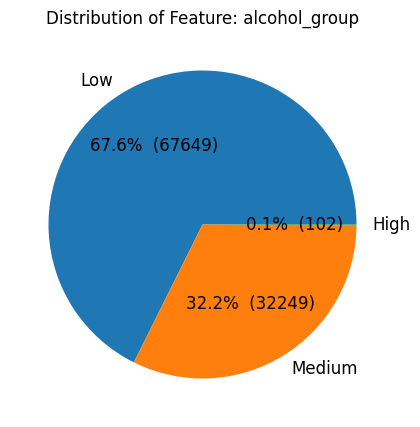

Number of unique values: 3

Distribution of alcohol_group by Target Variable


alcohol_group
Low       0.60
Medium    0.60
High      0.52
Name: diagnosed_diabetes, dtype: float64

In [ ]:
for col in cat_features:
    plot_pie_chart(df_clean_1, col, target_col_name='diagnosed_diabetes')

**Observations:**

- Some features show no difference in the mean value across the target, so I will not include them in the final dataset.

- Also, there seems to be a data leak - the feauture `diabetes_stage` contains a diagnosis already. 

## Removing unnecessary categoric features

In [ ]:
cat_features_to_remove = [
    'gender', 
    'ethnicity', 
    'education_level', 
    'income_level', 
    'employment_status', 
    'smoking_status',
    'alcohol_consumption_per_week',
    'diabetes_stage'   # data leak (!!!)
    ]

df_clean_2 = df_clean_1.drop(columns=cat_features_to_remove)

In [ ]:
df_clean_1.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,family_history_diabetes,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes,alcohol_group
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,0,...,41,160,145,136,6.36,8.18,29.6,Type 2,1,Low
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,0,...,55,50,30,93,2.00,5.63,23.0,No Diabetes,0,Low
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,1,...,66,99,36,118,5.07,7.51,44.7,Type 2,1,Low
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,0,...,50,79,140,139,5.28,9.03,38.2,Type 2,1,Low
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,0,...,52,125,160,137,12.74,7.20,23.5,Type 2,1,Low


In [ ]:
df_clean_2.head()

,age,physical_activity_minutes_per_week,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,systolic_bp,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,insulin_level,hba1c,diabetes_risk_score,diagnosed_diabetes,alcohol_group
0,58,215,0,0,0,30.5,134,41,160,145,136,6.36,8.18,29.6,1,Low
1,48,143,0,0,0,23.1,129,55,50,30,93,2.00,5.63,23.0,0,Low
2,60,57,1,0,0,22.2,115,66,99,36,118,5.07,7.51,44.7,1,Low
3,74,49,0,0,0,26.8,120,50,79,140,139,5.28,9.03,38.2,1,Low
4,46,109,0,0,0,21.2,92,52,125,160,137,12.74,7.20,23.5,1,Low


## Separating Test Set

In [ ]:
train, test = train_test_split(
    df_clean_2,
    test_size=0.2,
    random_state=42 
    )

In [ ]:
train.shape, test.shape

((80000, 16), (20000, 16))

# 02 Linear Model

In [ ]:
train.head()

,age,physical_activity_minutes_per_week,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,systolic_bp,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,insulin_level,hba1c,diabetes_risk_score,diagnosed_diabetes,alcohol_group
75220,62,79,0,0,1,23.5,115,51,50,112,104,6.42,6.28,29.9,0,Low
48955,44,88,0,0,0,25.5,115,66,83,137,108,10.06,6.40,25.8,0,Low
44966,45,82,0,0,0,28.6,107,47,132,66,94,11.16,6.27,26.6,1,Low
13568,40,202,0,0,0,28.5,128,50,109,153,107,4.87,6.41,21.3,0,Medium
92727,67,9,0,0,0,23.8,131,52,128,119,100,7.38,5.63,35.4,0,Low


## Data Preparation

### Log-transformation

In [ ]:
features_to_log = [
    'physical_activity_minutes_per_week',  
    'triglycerides',                       
    'insulin_level',                       
    'diabetes_risk_score'                  
]

In [ ]:
for feature in features_to_log:
    train[feature + '_log'] = np.log1p(train[feature])

### Separating numeric and categoric features

In [ ]:
continuous_features = [
    'age',
    'bmi', 
    'systolic_bp',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'glucose_fasting',
    'hba1c',
    'physical_activity_minutes_per_week_log',  
    'triglycerides_log',                       
    'insulin_level_log',                       
    'diabetes_risk_score_log'                  
]

binary_features = [
    'family_history_diabetes', 
    'hypertension_history', 
    'cardiovascular_history'
]

cat_features =['alcohol_group']

features = continuous_features + binary_features + cat_features

target = 'diagnosed_diabetes'

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2, random_state=42)

### Preprocessing & Training Pipeline

In [ ]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), continuous_features),
    ('encoder', OrdinalEncoder(categories=[['Low', 'Medium', 'High']]), cat_features),
    ('bin', 'passthrough', binary_features)
])

lin_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

### Hyperparametres Tuning

In [ ]:
space = {
    'classifier__C': hp.loguniform('classifier__C', np.log(0.001), np.log(100)),
    'classifier__max_iter': hp.quniform('classifier__max_iter', 500, 1000, 1)
}

def objective(params):
    params['classifier__max_iter'] = int(params['classifier__max_iter'])
    model = lin_pipe.set_params(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    score = roc_auc_score(y_val, y_pred)
    #score = recall_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  
    max_evals=50,      
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Best parametres for Logistic Regression:", best)

100%|██████████| 50/50 [00:11<00:00,  4.25trial/s, best loss: -0.8889389568419027]
Best parametres for Logistic Regression: {'classifier__C': np.float64(0.004677850435732884), 'classifier__max_iter': np.float64(719.0)}


# 03 Tree Model

In [ ]:
numeric_features = [
    'age',
    'bmi', 
    'systolic_bp',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'glucose_fasting',
    'hba1c',
    'physical_activity_minutes_per_week',  
    'triglycerides',                       
    'insulin_level',                       
    'diabetes_risk_score',                  
    'family_history_diabetes', 
    'hypertension_history', 
    'cardiovascular_history'
]

cat_features =['alcohol_group']

features = numeric_features + cat_features

target = 'diagnosed_diabetes'

x_train, x_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2, random_state=42)

In [ ]:
preprocessor = ColumnTransformer([
    ('encoder', OrdinalEncoder(categories=[['Low', 'Medium', 'High']]), cat_features),
    ('num', 'passthrough', numeric_features)
])

rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

space = {
    'classifier__n_estimators': hp.quniform('classifier__n_estimators', 50, 200, 10),
    'classifier__max_depth': hp.choice('classifier__max_depth', [None, 5, 10, 15, 20]),
    'classifier__min_samples_leaf': hp.choice('classifier__min_samples_leaf', [1, 5, 10, 20, 50])
}

def objective(params):
    params['classifier__n_estimators'] = int(params['classifier__n_estimators'])

    model = rf_pipe.set_params(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    score = roc_auc_score(y_val, y_pred )
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  
    max_evals=50,      
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Best parametres for Random Forest:", best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [04:07<00:00,  4.95s/trial, best loss: -0.9355341015260044]
Best parametres for Random Forest: {'classifier__max_depth': np.int64(3), 'classifier__min_samples_leaf': np.int64(3), 'classifier__n_estimators': np.float64(170.0)}


Ransom Forest shows a much higher metric (0.94) than the Linear Model (0.89). 

# 04 Boosting Model

In [ ]:
numeric_features = [
    'age',
    'bmi', 
    'systolic_bp',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'glucose_fasting',
    'hba1c',
    'physical_activity_minutes_per_week',  
    'triglycerides',                       
    'insulin_level',                       
    'diabetes_risk_score',                  
    'family_history_diabetes', 
    'hypertension_history', 
    'cardiovascular_history'
]

cat_features =['alcohol_group']

features = numeric_features + cat_features

target = 'diagnosed_diabetes'

x_train, x_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2, random_state=42)

x_train_enc = x_train.copy()
x_val_enc = x_val.copy()

for col in cat_features:
    x_train_enc[col] = x_train_enc[col].astype('category')
    x_val_enc[col] = x_val_enc[col].astype('category')

dtrain = xgb.DMatrix(x_train_enc, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(x_val_enc, label=y_val, enable_categorical=True)

In [ ]:
%%capture output

params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 1,
    'eval_metric': 'auc',
    'tree_method': 'hist'
}

watchlist = [(dtrain, 'train'), (dval, 'val')]


bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=watchlist,
    early_stopping_rounds=15
)

y_pred = bst.predict(dval)

In [ ]:
def parse_xgb_output(output):
    results = []
 
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
 
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
 
        results.append((it, train, val))
     
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
df_score = parse_xgb_output(output)

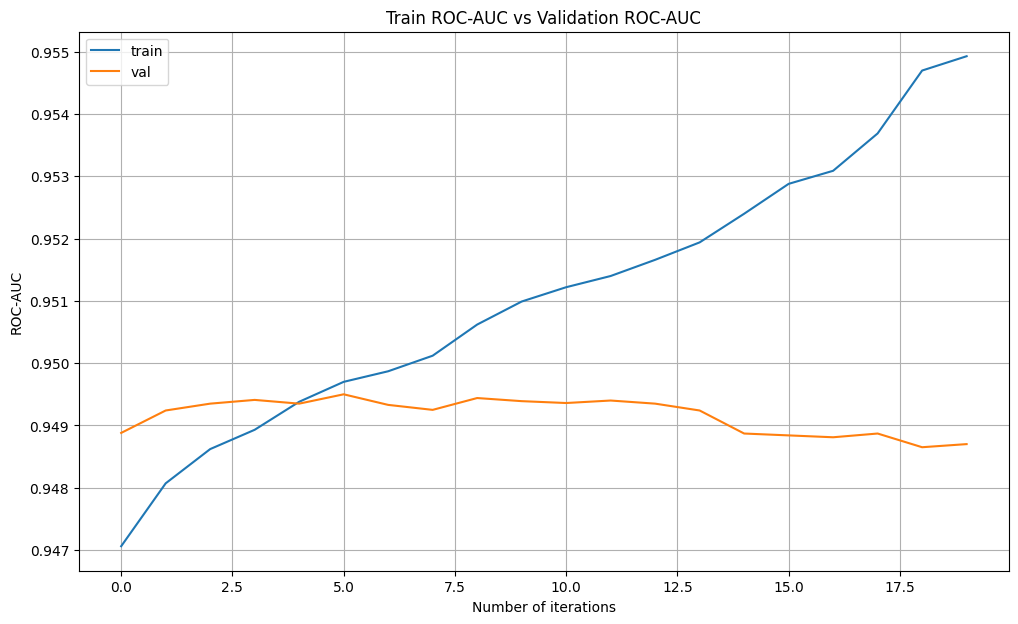

In [ ]:
plt.figure(figsize=(12, 7))

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.grid()
plt.legend()
plt.title('Train ROC-AUC vs Validation ROC-AUC')
plt.ylabel('ROC-AUC')
plt.xlabel('Number of iterations')

plt.show()

XGBoost shows an even better metric, however we can see that it starts to overfit after the 10th iteration. So I will tru fine tuning an reducing the number of iterations to 10. 

In [ ]:
from itertools import product

etas = [0.05, 0.1, 0.2]
depths = [3, 4, 6]
mcw = [1, 2, 5]

best_auc = 0
best_params = None

for eta, max_depth, min_child_weight in product(etas, depths, mcw):
    params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'seed': 1
    }
    
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        evals=[(dval, 'val')],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    auc = bst.best_score
    
    if auc > best_auc:
        best_auc = auc
        best_params = (eta, max_depth, min_child_weight)

print("Best AUC:", best_auc)
print("Best params:", best_params)

Best AUC: 0.9501723948997307
Best params: (0.1, 4, 1)


XGBoost shows the highest score (0.95), with the following parametres:
- `eta` = 0.1
- `max_depth` = 4
- `min_child_weight` = 1

# 05 Training Best Model & Prediction on Test

In [ ]:
numeric_features = [
    'age',
    'bmi', 
    'systolic_bp',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'glucose_fasting',
    'hba1c',
    'physical_activity_minutes_per_week',  
    'triglycerides',                       
    'insulin_level',                       
    'diabetes_risk_score',                  
    'family_history_diabetes', 
    'hypertension_history', 
    'cardiovascular_history'
]

cat_features =['alcohol_group']

features = numeric_features + cat_features

target = 'diagnosed_diabetes'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 1,
    'eval_metric': 'auc',
    'tree_method': 'hist'
}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200
)

y_pred = bst.predict(dtest)

/tmp/ipykernel_4033/1538214284.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
/tmp/ipykernel_4033/1538214284.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


In [ ]:
test_score = roc_auc_score(y_test, y_pred)
test_score

0.9446941696612112

The score on the test set is 0.94 and on validation it was 0.95, which is a great result. 